In [1]:
#### COMMENT OUT IF NOT USING GOOGLE COLAB ####
# import os
# from google.colab import drive
# drive.mount('/content/drive')

# # Set the path to project folder
# project_folder = '/content/drive/MyDrive/AAI-511-Final-Project'

# # Change the working directory to project folder
# os.chdir(project_folder)

# # Check the current working directory
# print(os.getcwd())

# # Install packages that are not on Google Colab
# !pip install keras_tuner
# !pip install pretty_midi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1G6OF4L9ScwOcw7r0vT-eDhzl9H2FGva6/AAI-511-Final-Project


In [75]:
# Basic libraries
import os
from PIL import Image
import gc

# Statistical libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from kerastuner.tuners import RandomSearch
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from keras_tuner import HyperParameters
import keras_tuner as kt


# MIDI libraries
import pretty_midi
import librosa


## Data Collection
We will be loading files in 2 ways:
- files loading for piano rolls generation
- labeled dataframe with features extracted:
    - `duration`
    - `tempo`
    - `avg_velocity`
    - `max_velocity`
    - `min_velocity`
    - `std_velocity`
    - `avg_pitch`
    - `max_pitch`
    - `min_pitch`
    - `pitch_std`
    - `avg_duration`
    - `max_duration`
    - `min_duration`
    - `uration_std`
    - `pitch_range`
    - `num_instruments`
    - `note_vector` -  the sequence of note pitches per midi file
    - `duration_vector`  -  the sequence of note durations per midi file
    - `velocity_vector` - the sequence of note velocities per midi file

In [34]:
# Specify the directory
bach_dir = 'music_data/midiclassics/Bach'
beethoven_dir = 'music_data/midiclassics/Beethoven'
chopin_dir = 'music_data/midiclassics/Chopin'
mozart_dir = 'music_data/midiclassics/Mozart'

composer_dirs = [bach_dir, beethoven_dir, chopin_dir, mozart_dir]

# Long Short-Term Memory

### LSTM - Data Preprocessing (Feature Extraction)

In [35]:
def extract_features(midi_file):
    midi_data = pretty_midi.PrettyMIDI(midi_file)

    
    # Extract note pitches
    pitches = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            pitches.append(note.pitch)    
            
    # Extract note durations
    durations = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            durations.append(note.end - note.start)
    
    # Extract note velocities
    velocities = []
    for instrument in midi_data.instruments:
        for note in instrument.notes:
            velocities.append(note.velocity)

     # Compute additional features
    duration = sum(durations)
    tempo = np.mean(midi_data.get_tempo_changes()[1]) if midi_data.get_tempo_changes()[1].size > 0 else 0
    avg_velocity = np.mean(velocities)
    max_velocity = np.max(velocities)
    min_velocity = np.min(velocities)
    std_velocity = np.std(velocities)

    avg_pitch = np.mean(pitches)
    max_pitch = np.max(pitches)
    min_pitch = np.min(pitches)
    pitch_std = np.std(pitches)

    avg_duration = np.mean(durations)
    max_duration = np.max(durations)
    min_duration = np.min(durations)
    duration_std = np.std(durations)
        
    pitch_range = np.max(pitches) - np.min(pitches)
    num_instruments = len(midi_data.instruments)
    note_density = len(pitches) / duration if duration > 0 else 0
    
    
    # Compute average and standard deviation for features
    features = {
        'duration': duration,
        'tempo': tempo,
        'avg_velocity': avg_velocity,
        'max_velocity': max_velocity,
        'min_velocity': min_velocity,
        'std_velocity': std_velocity,
        'avg_pitch': avg_pitch,
        'max_pitch': max_pitch,
        'min_pitch': min_pitch,
        'pitch_std': pitch_std,
        'avg_duration': avg_duration,
        'max_duration': max_duration,
        'min_duration': min_duration,
        'duration_std': duration_std,
        'pitch_range': pitch_range,
        'num_instruments': num_instruments,
        'note_density': note_density,

        'note_vector': pitches,  # Add the sequence of note pitches as a feature
        'duration_vector': durations,  # Add the sequence of note durations as a feature
        'velocity_vector': velocities  # Add the sequence of note velocities as a feature
    }
    
    return features


def load_data(directory, current_label, data, success_files, exception_files):
    print(f'Loading {directory} for {current_label}...')
       # Use os.walk to iterate over each subdirectory in the current directory
        # 'root' is the path to the current directory
        # 'dirs' is a list of the names of the subdirectories in 'root'
        # 'files' is a list of the names of the non-directory files in 'root'
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a MIDI file
            if file.endswith('.mid'):
                file_path = os.path.join(root, file)
                print(f'Processing {file}...')
                print(f'File path: {file_path}')
                try: 
                    features = extract_features(file_path)
                    features['composer'] = current_label
                    data.append(features)
                    success_files.append(file_path)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}") 
                    exception_files.append(file_path)

def create_dataframe(data, max_sequence_length = 100):
    df = pd.DataFrame(data)

    df['composer'] = df['composer'].map({0: 'Bach', 1: 'Beethoven', 2: 'Chopin', 3: 'Mozart'})
    df = pd.DataFrame(data)
    
    # Pad sequences to a fixed length
    note_vectors = pad_sequences(df['note_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    duration_vectors = pad_sequences(df['duration_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    velocity_vectors = pad_sequences(df['velocity_vector'].tolist(), maxlen=max_sequence_length, padding='post')
    
    # Add padded sequences to the dataframe
    df['note_vector'] = list(note_vectors)
    df['duration_vector'] = list(duration_vectors)
    df['velocity_vector'] = list(velocity_vectors)
    return df
            
data = []
success_files = []
exception_files = []

# Load data
for current_label, composer_dir in enumerate(composer_dirs):
    load_data(composer_dir, current_label, data, success_files, exception_files)

# Create dataframe
df = create_dataframe(data)

print(f"Success files: {len(success_files)}")
print(f"Exception files: {len(exception_files)}")

# Print shape of data
print(f"Data shape: {df.shape}")

# List all exceptions
for file in exception_files:
    print(file)

display(df.head())

Loading music_data/midiclassics/Bach for 0...
Processing Bwv0997 Partita for Lute 1mov.mid...
File path: music_data/midiclassics/Bach/Bwv0997 Partita for Lute 1mov.mid
Processing Bwv0535 Prelude and Fugue.mid...
File path: music_data/midiclassics/Bach/Bwv0535 Prelude and Fugue.mid
Processing Bwv0538 Toccata and Fugue Dorian.mid...
File path: music_data/midiclassics/Bach/Bwv0538 Toccata and Fugue Dorian.mid
Processing Bwv0806 English Suite n1 05mov.mid...
File path: music_data/midiclassics/Bach/Bwv0806 English Suite n1 05mov.mid
Processing Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid...
File path: music_data/midiclassics/Bach/Bwv0998 Prelude Fugue Allegro for Lute 3mov.mid
Processing Jesu Joy of Man Desiring.mid...
File path: music_data/midiclassics/Bach/Jesu Joy of Man Desiring.mid
Processing Prelude and Fugue in C Sharp BWV 872.mid...
File path: music_data/midiclassics/Bach/Prelude and Fugue in C Sharp BWV 872.mid
Processing Bwv0582 Passacaglia and Fugue.mid...
File path: music_dat

/Users/kseniakoldaeva/USD/AAI-511/AAI-511-final-project/final_project/lib/python3.10/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Processing Bwv0527 Sonate en trio n3.mid...
File path: music_data/midiclassics/Bach/Bwv0527 Sonate en trio n3.mid
Processing Bwv0806 English Suite n1 03mov .mid...
File path: music_data/midiclassics/Bach/Bwv0806 English Suite n1 03mov .mid
Processing Bwv0560 Short Prelude and Fugue n8 (Spurious).mid...
File path: music_data/midiclassics/Bach/Bwv0560 Short Prelude and Fugue n8 (Spurious).mid
Processing Bwv0811 English Suite n6 2mov.mid...
File path: music_data/midiclassics/Bach/Bwv0811 English Suite n6 2mov.mid
Processing Bwv1005 Violin Sonata n3 3mov Largo.mid...
File path: music_data/midiclassics/Bach/Bwv1005 Violin Sonata n3 3mov Largo.mid
Processing Bwv0559 Short Prelude and Fugue n7 (Spurious).mid...
File path: music_data/midiclassics/Bach/Bwv0559 Short Prelude and Fugue n7 (Spurious).mid
Processing Bwv0556 Short Prelude and Fugue n4 (Spurious).mid...
File path: music_data/midiclassics/Bach/Bwv0556 Short Prelude and Fugue n4 (Spurious).mid
Processing Bwv1014 Harpsicord and Violin S

duration       tempo  avg_velocity  max_velocity  min_velocity  \
0   310.437500   80.000000    100.000000           100           100   
1  1045.811182   56.538478     94.226798           102            92   
2  2568.338295   83.909554     93.416353           102            92   
3   263.753683  143.999885    107.000000           107           107   
4   180.900000   54.000000     97.967914           100            75   

   std_velocity  avg_pitch  max_pitch  min_pitch  pitch_std  ...  \
0      0.000000  67.425793         87         32  13.362625  ...   
1      3.158550  65.095977         84         36   8.985751  ...   
2      3.486757  62.401813         83         36   9.737270  ...   
3      0.000000  63.708571         83         33  12.281183  ...   
4      6.821956  56.748663         75         34   9.189533  ...   

   max_duration  min_duration  duration_std  pitch_range  num_instruments  \
0      1.000000      0.046875      0.217394           55                2   
1     13.974694      0.057692      0.483278           48                3   
2     20.957640      0.059055      0.538963           47                3   
3      1.916668      0.026042      0.257226           50                2   
4      7.500000      0.075000      0.475768           41                3   

   note_density                                        note_vector  \
0      3.147171  [41, 39, 51, 50, 51, 39, 38, 43, 36, 53, 51, 5...   
1      3.018709  [46, 45, 46, 41, 48, 43, 45, 38, 62, 61, 62, 5...   
2      2.276180  [52, 53, 52, 53, 52, 53, 52, 53, 52, 53, 52, 5...   
3      3.980987  [57, 57, 45, 38, 50, 49, 47, 49, 50, 47, 46, 4...   
4      4.134881  [48, 46, 48, 41, 44, 48, 41, 43, 45, 46, 38, 4...   

                                     duration_vector  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                     velocity_vector composer  
0  [100, 100, 100, 100, 100, 100, 100, 100, 100, ...        0  
1  [102, 102, 102, 102, 102, 102, 102, 102, 102, ...        0  
2  [102, 102, 102, 102, 102, 102, 102, 102, 102, ...        0  
3  [107, 107, 107, 107, 107, 107, 107, 107, 107, ...        0  
4  [100, 100, 100, 100, 100, 100, 100, 100, 100, ...        0  

[5 rows x 21 columns]

/var/folders/gs/bdy86gys0sl94djgd6hqvqd40000gq/T/ipykernel_63392/226832249.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='composer', data=df, palette='viridis')


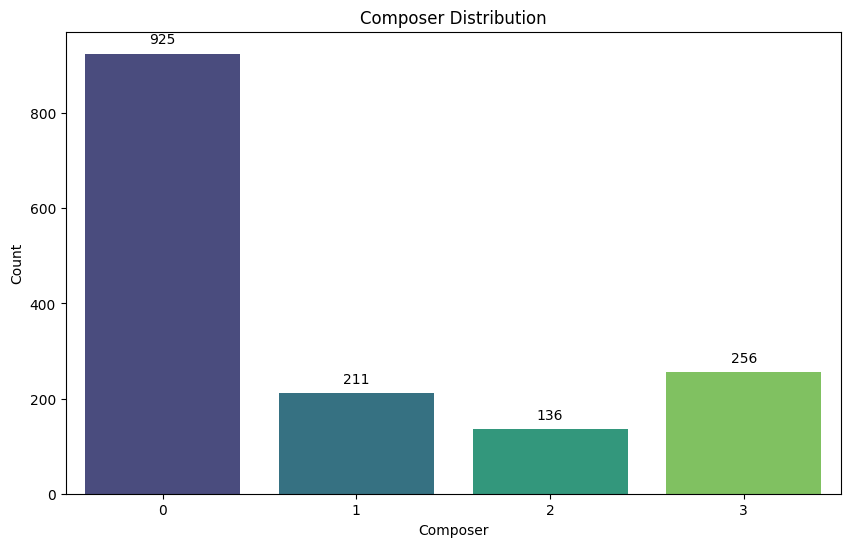

In [81]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='composer', data=df, palette='viridis')
plt.title('Composer Distribution')
plt.xlabel('Composer')
plt.ylabel('Count')

# Add numbers above each bar
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [82]:
# Print number of scores per composer
df['composer'].value_counts()

0    925
3    256
1    211
2    136
Name: composer, dtype: int64

/var/folders/gs/bdy86gys0sl94djgd6hqvqd40000gq/T/ipykernel_63392/2397650569.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='composer', y='avg_pitch', palette='viridis')


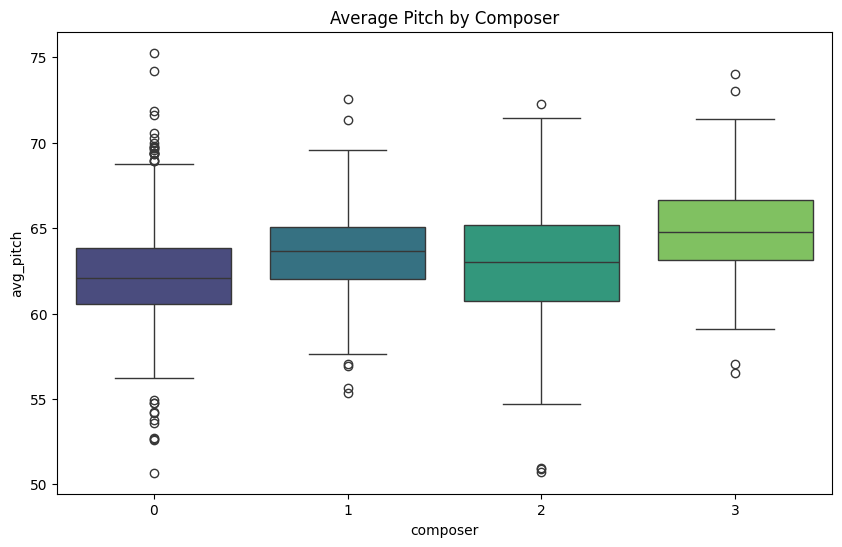

/var/folders/gs/bdy86gys0sl94djgd6hqvqd40000gq/T/ipykernel_63392/2397650569.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='composer', y='avg_duration', palette='viridis')


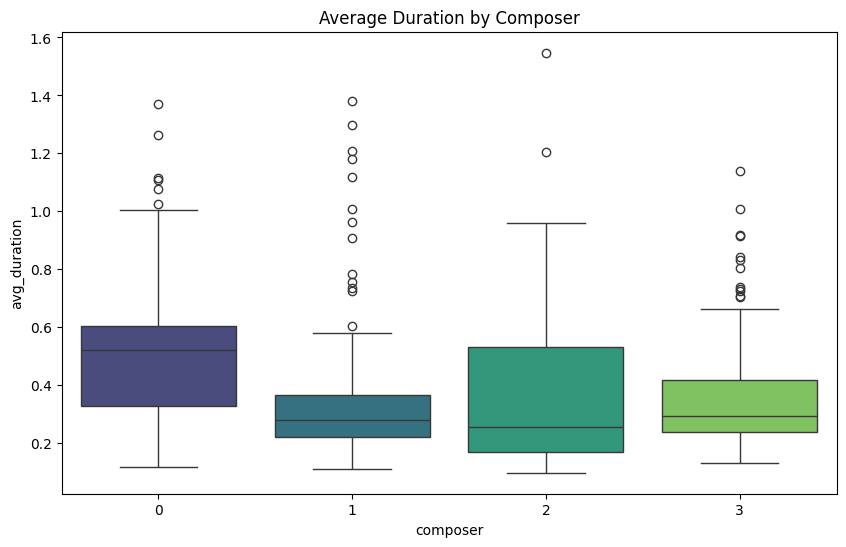

/var/folders/gs/bdy86gys0sl94djgd6hqvqd40000gq/T/ipykernel_63392/2397650569.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='composer', y='avg_velocity', palette='viridis')


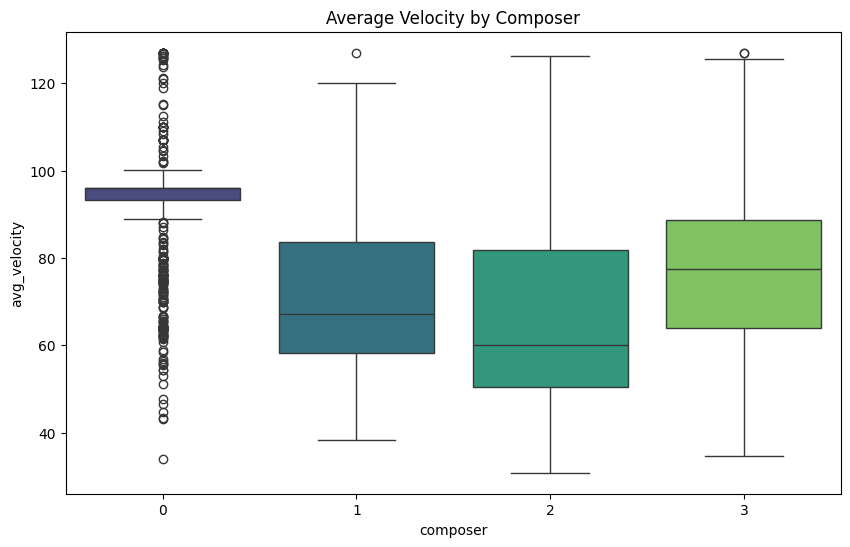

In [37]:
# plot average pitch for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_pitch', palette='viridis')
plt.title('Average Pitch by Composer')
plt.show()

# plot average duration for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_duration', palette='viridis')
plt.title('Average Duration by Composer')
plt.show()

# plot average velocity for each composer
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='composer', y='avg_velocity', palette='viridis')
plt.title('Average Velocity by Composer')
plt.show()

*Conclusion* 

The counts of musical scores per composer: 
- Bach - 925
- Beethoven - 256 
- Chopin - 211
- Mozart -  136

There is a class imbalance with Bach beeing the majority class and Mozart being the minority class. We will address the class imbalance in order to user the data in deep learning models. 

Additionally the box plots for pitch, velocity and duration distributions indicates variation per composer, signifying that these musical properties can be further used in deep learning models. 

We will use the following vectors for LSTM model 
- 'note_vector' - the sequence of note pitches as a feature
- 'duration_vector' - the sequence of note durations as a feature
- 'velocity_vector' - the velocities as a feature

Those features contain sequential aspect that LSTM models can capture well. 

### LSTM - Data Preprocessing (Address Class Imbalance)

In [38]:
# Prepare the dataset
X = df.drop(columns=['composer'])
y = df['composer']

# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the dataset into training and testing sets 
X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(X, y, test_size=0.2, random_state=42)

display(X_train_rs.head())

duration       tempo  avg_velocity  max_velocity  min_velocity  \
196   1912.107395   72.105315     55.688340            67            24   
1125  4009.458353  102.004132     57.895624           114            24   
1285   427.187073  110.000110     66.468101           108            45   
81     210.747750   65.418656     64.030162            90            64   
1431   126.759772   79.999995    100.000000           100           100   

      std_velocity  avg_pitch  max_pitch  min_pitch  pitch_std  avg_duration  \
196      10.357597  56.396427         79         24  10.597904      0.256866   
1125     17.566083  61.439617         89         26  12.182658      0.314418   
1285     21.890790  73.020753         88         49   9.789971      0.328353   
81        0.885050  61.286543         84         36  11.046843      0.244487   
1431      0.000000  62.393103         82         36   9.547555      0.218551   

      max_duration  min_duration  duration_std  pitch_range  num_instruments  \
196       3.000000      0.092592      0.129775           55                7   
1125     23.425646      0.034483      0.454033           63                5   
1285      1.636362      0.068182      0.305012           39                2   
81        4.052106      0.011111      0.274384           48                3   
1431      0.991667      0.075000      0.176499           46                2   

      note_density                                        note_vector  \
196       3.893087  [46, 46, 46, 51, 51, 51, 51, 51, 51, 51, 51, 5...   
1125      3.180479  [63, 65, 67, 69, 70, 68, 67, 65, 63, 62, 60, 5...   
1285      3.045504  [69, 71, 73, 74, 76, 73, 74, 76, 78, 73, 79, 6...   
81        4.090198  [55, 53, 55, 39, 49, 48, 46, 48, 49, 53, 51, 4...   
1431      4.575584  [57, 53, 58, 53, 57, 52, 48, 50, 52, 48, 53, 5...   

                                        duration_vector  \
196   [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1125  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1285  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...   
81    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1431  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                        velocity_vector  
196   [44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 4...  
1125  [76, 76, 77, 77, 78, 78, 79, 79, 80, 80, 81, 8...  
1285  [52, 56, 60, 64, 68, 76, 80, 84, 88, 92, 92, 9...  
81    [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6...  
1431  [100, 100, 100, 100, 100, 100, 100, 100, 100, ...

#### Undersampling

In [70]:
# Use RandomUnderSampler to handle class imbalance for training data

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_undersampled, y_undersampled = rus.fit_resample(X_train_rs, y_train_rs)

# Convert resampled data back to DataFrame for easier handling
X_undersampled_df = pd.DataFrame(X_undersampled, columns=X.columns)
y_undersampled_df = pd.Series(y_undersampled, name='composer')

# Verify class distribution after undersampling
print(y_undersampled_df.value_counts())

# Print fist 5 rows of X_undersampled_df
display(X_undersampled_df.head())

# Print fist 5 values of y_undersampled_df
print(y_undersampled_df.head())

# shape of y_undersampled_df
print(y_undersampled_df.shape)

0    108
1    108
2    108
3    108
Name: composer, dtype: int64


duration      tempo  avg_velocity  max_velocity  min_velocity  \
217   105.714180  84.000084     96.000000            96            96   
888  1401.102172  59.500031     72.134002            76            52   
178  1253.025411  61.550029     43.368296            52            17   
533   182.856960  84.000084     96.000000            96            96   
267   137.500000  96.000000     96.000000            96            96   

     std_velocity  avg_pitch  max_pitch  min_pitch  pitch_std  avg_duration  \
217      0.000000  58.589888         72         38   7.067516      0.593900   
888      5.362214  67.631232         90         38  10.149274      0.369586   
178      7.349057  57.043664         79         24  11.863725      0.594696   
533      0.000000  61.912698         76         43   7.912237      0.725623   
267      0.000000  63.064220         78         42   7.384928      0.630734   

     max_duration  min_duration  duration_std  pitch_range  num_instruments  \
217      1.428570      0.178571      0.221189           34                4   
888      2.924359      0.032609      0.281161           52                6   
178     10.080038      0.070312      0.853214           55                5   
533      2.142855      0.357142      0.420744           33                4   
267      1.250000      0.312500      0.231782           36                4   

     note_density                                        note_vector  \
217      1.683785  [62, 62, 62, 58, 58, 57, 55, 57, 62, 60, 58, 5...   
888      2.705727  [73, 62, 66, 50, 71, 66, 62, 47, 59, 73, 64, 5...   
178      1.681530  [47, 48, 47, 48, 47, 48, 47, 48, 47, 48, 47, 4...   
533      1.378126  [60, 62, 64, 65, 64, 62, 56, 64, 64, 62, 60, 6...   
267      1.585455  [62, 57, 57, 59, 61, 61, 62, 59, 61, 62, 61, 5...   

                                       duration_vector  \
217  [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
888  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
178  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
533  [0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, ...   
267  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                       velocity_vector  
217  [96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 9...  
888  [72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 72, 7...  
178  [47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 47, 4...  
533  [96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 9...  
267  [96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 96, 9...

217    0
888    0
178    0
533    0
267    0
Name: composer, dtype: int64
(432,)


#### Oversampling

In [71]:
# Use Random Oversampling by copying the minority class

# Perform random oversampling on the training set
ros = RandomOverSampler(random_state=42)
X_oversampled, y_oversampled = ros.fit_resample(X_train_rs, y_train_rs)

# Convert resampled data back to DataFrame for easier handling (optional)
X_oversampled_df = pd.DataFrame(X_oversampled, columns=X.columns)
y_oversampled_df = pd.Series(y_oversampled, name='composer')

# Print first 5 rows of X_oversampled_df
display(X_oversampled_df.head())

# Print first 5 values of y_oversampled_df
print(y_oversampled_df.head())

# Display the resampled training set
print(y_oversampled_df.value_counts())

duration       tempo  avg_velocity  max_velocity  min_velocity  \
0  1912.107395   72.105315     55.688340            67            24   
1  4009.458353  102.004132     57.895624           114            24   
2   427.187073  110.000110     66.468101           108            45   
3   210.747750   65.418656     64.030162            90            64   
4   126.759772   79.999995    100.000000           100           100   

   std_velocity  avg_pitch  max_pitch  min_pitch  pitch_std  avg_duration  \
0     10.357597  56.396427         79         24  10.597904      0.256866   
1     17.566083  61.439617         89         26  12.182658      0.314418   
2     21.890790  73.020753         88         49   9.789971      0.328353   
3      0.885050  61.286543         84         36  11.046843      0.244487   
4      0.000000  62.393103         82         36   9.547555      0.218551   

   max_duration  min_duration  duration_std  pitch_range  num_instruments  \
0      3.000000      0.092592      0.129775           55                7   
1     23.425646      0.034483      0.454033           63                5   
2      1.636362      0.068182      0.305012           39                2   
3      4.052106      0.011111      0.274384           48                3   
4      0.991667      0.075000      0.176499           46                2   

   note_density                                        note_vector  \
0      3.893087  [46, 46, 46, 51, 51, 51, 51, 51, 51, 51, 51, 5...   
1      3.180479  [63, 65, 67, 69, 70, 68, 67, 65, 63, 62, 60, 5...   
2      3.045504  [69, 71, 73, 74, 76, 73, 74, 76, 78, 73, 79, 6...   
3      4.090198  [55, 53, 55, 39, 49, 48, 46, 48, 49, 53, 51, 4...   
4      4.575584  [57, 53, 58, 53, 57, 52, 48, 50, 52, 48, 53, 5...   

                                     duration_vector  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2  [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...   
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                     velocity_vector  
0  [44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 4...  
1  [76, 76, 77, 77, 78, 78, 79, 79, 80, 80, 81, 8...  
2  [52, 56, 60, 64, 68, 76, 80, 84, 88, 92, 92, 9...  
3  [64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 64, 6...  
4  [100, 100, 100, 100, 100, 100, 100, 100, 100, ...

0    0
1    1
2    3
3    0
4    3
Name: composer, dtype: int64
0    750
1    750
3    750
2    750
Name: composer, dtype: int64


### LSTM - Data Preprocessing 

In [41]:
# Function to scale vector features
def scale_vectors(vector_series, scaler):
    scaled_vectors = np.array([scaler.fit_transform(np.array(vec).reshape(-1, 1)).flatten() for vec in vector_series])
    return scaled_vectors

# Initialize the scalers
note_vector_scaler = StandardScaler()
duration_vector_scaler = StandardScaler()
velocity_vector_scaler = StandardScaler()

# Apply scaling to note_vector, duration_vector, and velocity_vector for undersampled data
note_vectors_un = scale_vectors(X_undersampled_df['note_vector'], note_vector_scaler)
duration_vectors_un = scale_vectors(X_undersampled_df['duration_vector'], duration_vector_scaler)
velocity_vectors_un = scale_vectors(X_undersampled_df['velocity_vector'], velocity_vector_scaler)

# Combine vectors into 3D array: (num_samples, sequence_length, num_features)
X_train_vectors_un = np.stack((note_vectors_un, duration_vectors_un, velocity_vectors_un), axis=-1)

# Apply scaling to note_vector, duration_vector, and velocity_vector for oversampled data
note_vectors_os = scale_vectors(X_oversampled_df['note_vector'], note_vector_scaler)
duration_vectors_os = scale_vectors(X_oversampled_df['duration_vector'], duration_vector_scaler)
velocity_vectors_os = scale_vectors(X_oversampled_df['velocity_vector'], velocity_vector_scaler)

# Combine vectors into 3D array: (num_samples, sequence_length, num_features)
X_train_vectors_os = np.stack((note_vectors_os, duration_vectors_os, velocity_vectors_os), axis=-1)

# Apply scaling to note_vector, duration_vector, and velocity_vector for test data
note_vectors_test = scale_vectors(X_test_rs['note_vector'], note_vector_scaler)
duration_vectors_test = scale_vectors(X_test_rs['duration_vector'], duration_vector_scaler)
velocity_vectors_test = scale_vectors(X_test_rs['velocity_vector'], velocity_vector_scaler)

# Combine vectors into 3D array: (num_samples, sequence_length, num_features)
X_test_vectors = np.stack((note_vectors_test, duration_vectors_test, velocity_vectors_test), axis=-1)

# Print shape of the input data
print(f"X_train_vectors shape from undersampled data: {X_train_vectors_un.shape}")  # Should be (num_samples, sequence_length, num_features)
print(f"X_train_vectors shape from oversampled data: {X_train_vectors_os.shape}")  # Should be (num_samples, sequence_length, num_features)
print(f"X_test_vectors shape: {X_test_vectors.shape}")  # Should be (num_samples, sequence_length, num_features)

X_train_vectors shape from undersampled data: (432, 100, 3)
X_train_vectors shape from oversampled data: (3000, 100, 3)
X_test_vectors shape: (306, 100, 3)


### Helper Functions

In [60]:
def plot_loss(history, title):
    # Access the training history directly from the model
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [78]:
def evaluate_model(model, x, y):
    """
    Evaluates a given model on the provided data and returns various metrics.

    Parameters:
    - model: The trained model to be evaluated.
    - x: Input features for the evaluation.
    - y: True labels for the evaluation.

    Returns:
    - y_pred: Predicted labels.
    - y_true: True labels.
    - accuracy: Accuracy of the model.
    - loss: Loss of the model.
    - recall: Recall of the model.
    - precision: Precision of the model.
    - f1: F1 score of the model.
    - roc_auc: ROC AUC score of the model.
    """
    
    # Get the model predictions (probabilities)
    y_pred_probs = model.predict(x)
    
    # Convert probabilities to class predictions
    y_pred = np.argmax(y_pred_probs, axis=1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y, y_pred)
    
    # Calculate loss
    loss = model.evaluate(x, y, verbose=0)[0]
    
    # Calculate recall
    recall = recall_score(y, y_pred, average='weighted')
    
    # Calculate precision
    precision = precision_score(y, y_pred, average='weighted')
    
    # Calculate F1 score
    f1 = f1_score(y, y_pred, average='weighted')
    
    # Calculate ROC AUC score
    # Note: roc_auc_score requires one-hot encoded labels for multi-class
    y_one_hot = tf.keras.utils.to_categorical(y, num_classes=len(np.unique(y)))
    roc_auc = roc_auc_score(y_one_hot, y_pred_probs, multi_class='ovr')
    
    return y_pred, y, accuracy, loss, recall, precision, f1, roc_auc


### LSTM - Model Building

In [42]:
# Define the LSTM model for undersampled data
model_un = Sequential([
    LSTM(64, input_shape=(X_train_vectors_un.shape[1], X_train_vectors_un.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model_un.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_un.summary()


# Define the LSTM model for oversampled data

model_os = Sequential([
    LSTM(64, input_shape=(X_train_vectors_os.shape[1], X_train_vectors_os.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(64, activation='relu'),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model_os.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model_os.summary()


/Users/kseniakoldaeva/USD/AAI-511/AAI-511-final-project/final_project/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,852 (214.27 KB)

 Trainable params: 54,852 (214.27 KB)

 Non-trainable params: 0 (0.00 B)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 100, 64)        │        17,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,852 (214.27 KB)

 Trainable params: 54,852 (214.27 KB)

 Non-trainable params: 0 (0.00 B)

### LSTM - Model Training

In [43]:
# Train the model with undersampled data
history_un = model_un.fit(X_train_vectors_un, y_undersampled, epochs=50, batch_size=32, validation_split=0.2)

# Train the model with oversampled data 
history_os = model_os.fit(X_train_vectors_os, y_oversampled, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.3164 - loss: 1.3612 - val_accuracy: 0.0000e+00 - val_loss: 1.6695
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5407 - loss: 1.2114 - val_accuracy: 0.0000e+00 - val_loss: 1.9710
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6180 - loss: 1.0849 - val_accuracy: 0.0000e+00 - val_loss: 2.4447
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.6314 - loss: 0.8928 - val_accuracy: 0.0000e+00 - val_loss: 2.7916
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6810 - loss: 0.8666 - val_accuracy: 0.0000e+00 - val_loss: 2.7434
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6650 - loss: 0.8898 - val_accuracy: 0.0000e+00 - val_loss: 2.4987
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6684 - loss: 0.8347 - val_accuracy: 0.0000e+00 - val_loss: 2.6236
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7015 - loss: 0.789

### LSTM - Model Evaluation

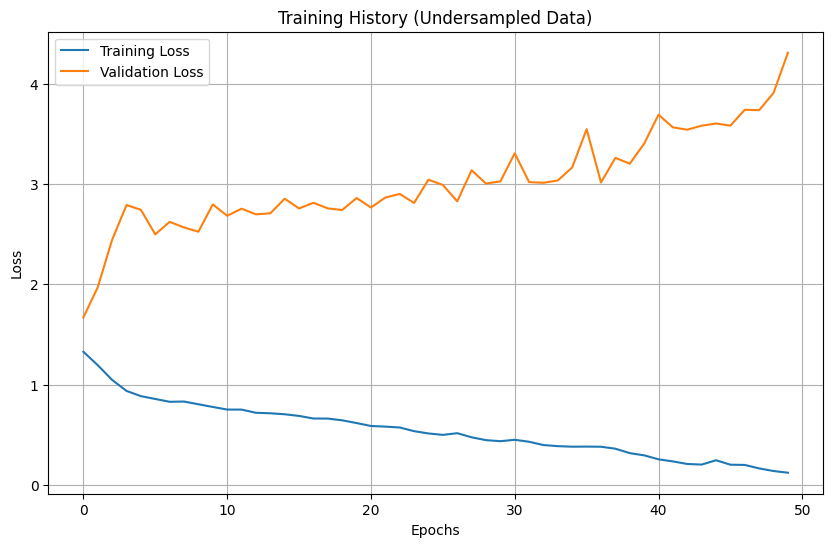

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Accuracy: 0.630718954248366
Loss: 1.6287643909454346
Recall: 0.630718954248366
Precision: 0.6965142505609608
F1 Score: 0.6356525984405167
ROC AUC Score: 0.8053439391514277


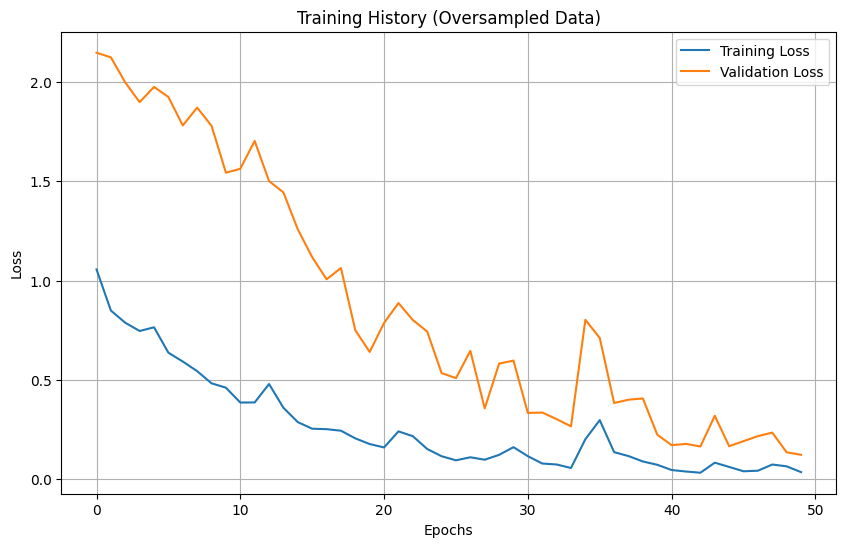

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step
Accuracy: 0.673202614379085
Loss: 1.8880733251571655
Recall: 0.673202614379085
Precision: 0.6742664935871863
F1 Score: 0.6727126807523504
ROC AUC Score: 0.8339562883777962


In [79]:
# Plot the training history for undersampled data
plot_loss(history_un, title='Training History (Undersampled Data)')

# Evaluate the model with undersampled data
y_pred_un, y_true_un, accuracy_un, loss_un, recall_un, precision_un, f1_un, roc_auc_un = evaluate_model(model_un, X_test_vectors, y_test_rs)

# Print evaluation metrics for undersampled data
print(f"Accuracy: {accuracy_un}")
print(f"Loss: {loss_un}")
print(f"Recall: {recall_un}")
print(f"Precision: {precision_un}")
print(f"F1 Score: {f1_un}")
print(f"ROC AUC Score: {roc_auc_un}")


# Plot the training history for oversampled data
plot_loss(history_os, title='Training History (Oversampled Data)')
# Evaluate the model with oversampled data
y_pred_os, y_true_os, accuracy_os, loss_os, recall_os, precision_os, f1_os, roc_auc_os = evaluate_model(model_os, X_test_vectors, y_test_rs)

# Print evaluation metrics for oversampled data
print(f"Accuracy: {accuracy_os}")
print(f"Loss: {loss_os}")
print(f"Recall: {recall_os}")
print(f"Precision: {precision_os}")
print(f"F1 Score: {f1_os}")
print(f"ROC AUC Score: {roc_auc_os}")



#### LSTM preliminary conclusions 

- The test accuracy for LSTM model with undersampled data is relatively lower. It might be due to the reduced amount of training data after undersampling, which can lead to less representative training data and potentially poorer model performance.
- The test accuracy for LSTM model with oversampled data is higher, it suggests that the oversampling strategy helped balance the class distribution without reducing the amount of training data, leading to better model performance.

### LSTM - Model Optimization 

We are going to futher optimize the model with oversampled data.


In [51]:
def build_lstm_model(hp):
    """
    Builds a Long Short-Term Memory (LSTM) network model with hyperparameters.

    The function creates a Sequential model and adds layers to it based on the
    hyperparameters provided. The hyperparameters include the number of LSTM
    units, the number of LSTM layers, the dropout rate, and the learning rate
    for the Adam optimizer.

    Parameters:
    hp : HyperParameters
        An instance of Keras Tuner HyperParameters. This object allows you to
        define a hyperparameter search space in a user-friendly way.

    Returns:
    model : Sequential
        The built Keras model. The model is compiled but not trained.
    """

    model = Sequential()


    # Add a variable number of LSTM layers
    for i in range(hp.Int('num_lstm_layers', 1, 3)):
        model.add(LSTM(
            units=hp.Int(f'lstm_units_{i+1}', min_value=32, max_value=256, step=32),
            return_sequences=(i != hp.Int('num_lstm_layers', 1, 3) - 1),  # Return sequences only for non-final layers
            input_shape=(X_train_vectors_os.shape[1], X_train_vectors_os.shape[2]) if i == 0 else None,
        ))
        model.add(Dropout(rate=hp.Float(f'dropout_lstm_{i+1}', min_value=0.1, max_value=0.5, step=0.1)))

     # Tuning the Dense layer
    model.add(Dense(
        units=hp.Int('dense_units', min_value=32, max_value=512, step=32),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_dense', min_value=0.1, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(len(label_encoder.classes_), activation='softmax'))

    # Compile the model

    # Tuning the learning rate
    lr = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    model.compile(
        optimizer=Adam(learning_rate=lr),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [53]:
#### CODE BLOCK COMMENTED OUT TO PREVENT RUNNING TUNING ####
#### TRIAL RESULTS SAVED ON GITHUB IN "MY_DIR" FOLDER ####

# Define the tuner
lstm_tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=50,  # Specify the number of trials
    directory='my_dir',
    project_name='lstm_hyperparameter_tuning'
) 

# # Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# lstm_tuner.search(X_train_vectors_os, y_oversampled, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 50 Complete [00h 14m 30s]
val_accuracy: 0.9983333349227905

Best val_accuracy So Far: 1.0
Total elapsed time: 03h 20m 17s

The optimal number of LSTM layers is 3.
The optimal number of units in the LSTM layers are [224, 128, 256].
The optimal number of units in the dense layer is 384.
The optimal dropout rates are [0.2, 0.4, 0.1] and 0.1 for the dense layer.
The optimal learning rate is 0.001.



In [56]:
# # Get the optimal hyperparameters
best_hps = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The optimal number of LSTM layers is {best_hps.get('num_lstm_layers')}.
The optimal number of units in the LSTM layers are {[best_hps.get(f'lstm_units_{i+1}') for i in range(best_hps.get('num_lstm_layers'))]}.
The optimal number of units in the dense layer is {best_hps.get('dense_units')}.
The optimal dropout rates are {[best_hps.get(f'dropout_lstm_{i+1}') for i in range(best_hps.get('num_lstm_layers'))]} and {best_hps.get('dropout_dense')} for the dense layer.
The optimal learning rate is {best_hps.get('learning_rate')}.
""")


The optimal number of LSTM layers is 3.
The optimal number of units in the LSTM layers are [224, 128, 256].
The optimal number of units in the dense layer is 384.
The optimal dropout rates are [0.2, 0.4, 0.1] and 0.1 for the dense layer.
The optimal learning rate is 0.001.



In [58]:
# Results from all trials
lstm_tuner.results_summary()

# Build the model with the optimal hyperparameters and train it
model_os_opt = lstm_tuner.hypermodel.build(best_hps)
history = model_os_opt.fit(X_train_vectors_os, y_oversampled, epochs=50, validation_split=0.2)


Results summary
Results in my_dir/lstm_hyperparameter_tuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 16 summary
Hyperparameters:
num_lstm_layers: 3
lstm_units_1: 224
dropout_lstm_1: 0.2
dense_units: 384
dropout_dense: 0.1
learning_rate: 0.001
lstm_units_2: 128
dropout_lstm_2: 0.4
lstm_units_3: 256
dropout_lstm_3: 0.1
Score: 1.0

Trial 22 summary
Hyperparameters:
num_lstm_layers: 1
lstm_units_1: 256
dropout_lstm_1: 0.2
dense_units: 416
dropout_dense: 0.4
learning_rate: 0.001
lstm_units_2: 96
dropout_lstm_2: 0.30000000000000004
lstm_units_3: 192
dropout_lstm_3: 0.4
Score: 1.0

Trial 33 summary
Hyperparameters:
num_lstm_layers: 1
lstm_units_1: 256
dropout_lstm_1: 0.1
dense_units: 224
dropout_dense: 0.2
learning_rate: 0.001
lstm_units_2: 224
dropout_lstm_2: 0.1
lstm_units_3: 32
dropout_lstm_3: 0.2
Score: 1.0

Trial 46 summary
Hyperparameters:
num_lstm_layers: 2
lstm_units_1: 64
dropout_lstm_1: 0.1
dense_units: 288
dropout_dense: 0.1
learning_rate: 0.00

### LSTM Model Evaluation

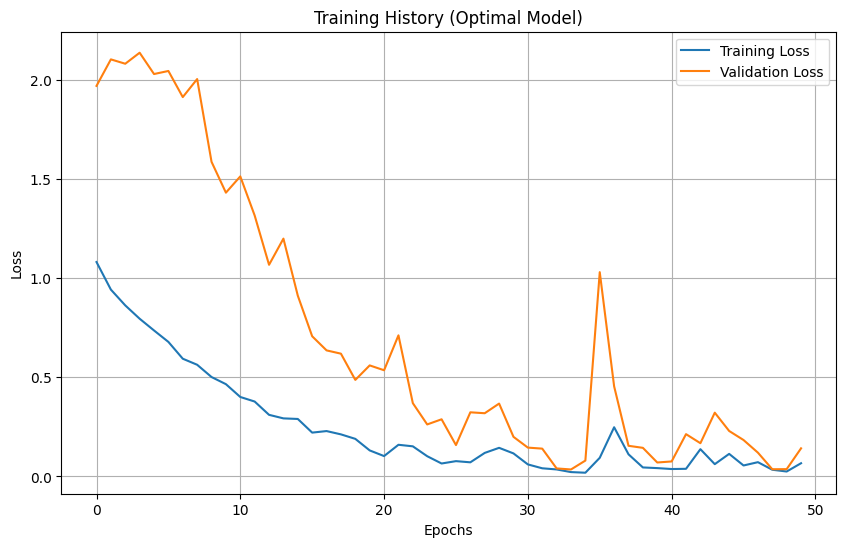

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step
Accuracy: 0.6699346405228758
Loss: 1.9445613622665405
Recall: 0.6699346405228758
Precision: 0.6647253046201024
F1 Score: 0.6605604470132099
ROC AUC Score: 0.847499972640227


In [80]:
# Plot the training history
plot_loss(history, title='Training History (Optimal Model)')
# Evaluate the model with optimal hyperparameters
y_pred_opt, y_true_opt, accuracy_opt, loss_opt, recall_opt, precision_opt, f1_opt, roc_auc_opt = evaluate_model(model_os_opt, X_test_vectors, y_test_rs)

# Print evaluation metrics for the optimal model
print(f"Accuracy: {accuracy_opt}")
print(f"Loss: {loss_opt}")
print(f"Recall: {recall_opt}")
print(f"Precision: {precision_opt}")
print(f"F1 Score: {f1_opt}")
print(f"ROC AUC Score: {roc_auc_opt}")


#### Data Preparation

Data Splitting: The data was split into training and test sets before addressing class imbalance.
Feature Scaling: The feature vectors (note_vector, duration_vector, velocity_vector) were scaled to standardize their ranges.

#### Handling Class Imbalance
1. Undersampling:
- Training History: The validation loss increased over time, indicating potential overfitting.
- Evaluation Metrics:
    - Accuracy: 0.63
    - Loss: 1.63
    - Recall: 0.63
    - Precision: 0.70
    - F1 Score: 0.64
    - ROC AUC Score: 0.81

2. Oversampling:

- Training History: The training history plot appeared correct without signs of overfitting.
- Evaluation Metrics:
    - Accuracy: 0.67
    - Loss: 1.88
    - Recall: 0.67
    - Precision: 0.67
    - F1 Score: 0.67
    - ROC AUC Score: 0.83

#### Hyperparameter Tuning
- *Best Hyperparameters:*
    - Number of LSTM layers: 3
    - LSTM units for each layer: 224, 128, 256
    - Dropout rates: 0.2, 0.4, 0.1 for each LSTM layer
    - Dense layer units: 384
    - Dropout rate for dense layer: 0.1
    - Learning rate: 0.001

- *Results with Optimal Hyperparameters on Oversampled Data:*

- Training History: Good looking history plot, indicating well-behaved training and validation curves.
    - Evaluation Metrics:
    - Accuracy: 0.67
    - Loss: 1.94
    - Recall: 0.67
    - Precision: 0.66
    - F1 Score: 0.66
    - ROC AUC Score: 0.85


#### Analysis

1. Undersampling:

The model trained on undersampled data exhibited overfitting, as evidenced by the increasing validation loss.
Despite overfitting, the model achieved a reasonable ROC AUC score, indicating that it was able to discriminate between classes to some extent.

2. Oversampling:

The model trained on oversampled data had a more stable training history and better overall metrics compared to the undersampled model.
The results indicate that oversampling helped the model generalize better to the test data, with a higher ROC AUC score and balanced precision and recall.

3. Hyperparameter Tuning:

Hyperparameter tuning on the oversampled data further improved the model's performance, achieving the highest ROC AUC score among all models.
The tuned model's training history plot showed no signs of overfitting, suggesting that the optimal hyperparameters and oversampling strategy together led to a well-generalized model.

#### Recommendations

1. Oversampling Strategy:

Continue using oversampling to address class imbalance, as it led to better generalization compared to undersampling.

2. Hyperparameter Tuning:

Regularly perform hyperparameter tuning to find the best model configuration, especially look at the regularization technique to achieve test data performance comparable to the validaton accuracy during training. 

3. Feature Scaling:

Consider training the model on unscaled data, as there feature vectors are already relatively consistent and meaningful, scaling might not be necessary. 

2. Model Monitoring:

Continue monitoring training history plots to ensure the model does not overfit and maintains good generalization.
By following these strategies, the model performance on unseen data can be improved, leading to more reliable and robust predictions.

# Convolution Neural Networks

### CNN - Data Preprocessing

In [4]:
def compile_midi_files(directory):
    # Initialize an empty list to store the paths of all MIDI files
    midi_files = []

    # Use os.walk to iterate over each subdirectory in the current directory
        # 'root' is the path to the current directory
        # 'dirs' is a list of the names of the subdirectories in 'root'
        # 'files' is a list of the names of the non-directory files in 'root'
    for root, dirs, files in os.walk(directory):
        for file in files:
            # Check if the file is a MIDI file
            if file.endswith('.mid'):
                # If it is, construct the full path to the file and add to list
                midi_files.append(os.path.join(root, file))

    # Return the list of all MIDI files
    return midi_files

# Compile all MIDI files from each composer
bach_midi_files = compile_midi_files(bach_dir)
beethoven_midi_files = compile_midi_files(beethoven_dir)
chopin_midi_files = compile_midi_files(chopin_dir)
mozart_midi_files = compile_midi_files(mozart_dir)

# Print the number of MIDI files for each composer
print(f'Bach MIDI files: {len(bach_midi_files)}')
print(f'Beethoven MIDI files: {len(beethoven_midi_files)}')
print(f'Chopin MIDI files: {len(chopin_midi_files)}')
print(f'Mozart MIDI files: {len(mozart_midi_files)}')

Bach MIDI files: 925
Beethoven MIDI files: 212
Chopin MIDI files: 136
Mozart MIDI files: 257


### CNN - Data Preprocessing (Address Class Imbalance)

In [5]:
#### CODE BLOCK COMMENTED OUT SINCE IMAGE FILES HAVE ALREADY BEEN CREATED ####
#### FOLDER OF IMAGES CAN BE FOUND ON GITHUB TITLED "PIANO_ROLLS_IMAGES" ####

# # Randomly sample 136 MIDI files from each composer
# np.random.seed(0)
# bach_sample = np.random.choice(bach_midi_files, 136, replace=False)
# beethoven_sample = np.random.choice(beethoven_midi_files, 136, replace=False)
# chopin_sample = np.random.choice(chopin_midi_files, 136, replace=False)
# mozart_sample = np.random.choice(mozart_midi_files, 136, replace=False)

### CNN - Data Preprocessing (Feature Extraction)

In [60]:
def save_piano_roll_png(midi_files, subfolder=''):
    """
    This function iterates over each MIDI file in the array of MIDI
    files passed in, converts the MIDI file into a PrettyMIDI object,
    plots the piano roll by using Librosa's specshow function, and then
    saves the image in the composer's folder.

    Args:
        midi_files (numpy array): List of midi files
        subfolder (string): Name of folder by composer
    """
    # Iterate over each MIDI file
    for midi_file_path in midi_files:
        try:
            # Convert the MIDI file to a PrettyMIDI object
            pm = pretty_midi.PrettyMIDI(midi_file_path)

            # Use librosa's specshow function for displaying the piano roll
            start_pitch = 21
            end_pitch = 108
            librosa.display.specshow(pm.get_piano_roll(50)[start_pitch:end_pitch],
                             hop_length=1, sr=50, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

            # Save the figure to a PNG file
            image_path = f'piano_roll_images/{subfolder}/' \
                         f'{os.path.basename(midi_file_path)}.png'
            plt.savefig(image_path)

        except Exception as e:
            print(f"Skipping file {midi_file_path} due to error: {e}")
            continue


In [ ]:
#### CODE BLOCKS COMMENTED OUT SINCE IMAGE FILES HAVE ALREADY BEEN CREATED ####
#### FOLDER OF IMAGES CAN BE FOUND ON GITHUB TITLED 'PIANO_ROLLS_IMAGES ####

## Execute function to create and save piano rolls for composers' Midi files

# save_piano_roll_png(bach_sample, subfolder='Bach')

In [ ]:
# save_piano_roll_png(beethoven_sample, subfolder='Beethoven')

In [ ]:
# save_piano_roll_png(chopin_sample, subfolder='Chopin')

In [ ]:
# save_piano_roll_png(mozart_sample, subfolder='Mozart')

In [19]:
def create_df(directory, composer):
    """
    This function creates a pandas DataFrame containing the names of
    all files in a specified directory and associates each file with
    a specified composer.

    Args:
    directory (str): The path to the directory containing the files.
    composer (str): The name of the composer to associate with each file.

    Returns:
    df (pandas.DataFrame): A DataFrame where each row represents a file.
    The DataFrame has two columns: 'image_id', which contains the file names,
    and 'composer', which contains the composer associated with each file.
    """
    # Get a list of all file names in the directory
    file_names = [f for f in os.listdir(directory) if f.endswith('.png')]

    # Create a list with the composer name repeated for each image
    labels = [composer] * len(file_names)

    # Create a DataFrame with the image ids and composers
    df = pd.DataFrame({
        'image_id': file_names,
        'composer': labels
    })

    return df

In [20]:
# Execute function to create dataframe with all the image IDs for Bach
bach_pr_df = create_df('piano_roll_images/Bach', 'bach')
print(bach_pr_df.head())

                                       image_id composer
0  Bwv1058 Harpsichord Concerto n7 1mov.mid.png     bach
1                  08. Chor Qui Tollis .mid.png     bach
2                              006206b_.mid.png     bach
3                              006507b_.mid.png     bach
4                              065200b_.mid.png     bach


In [21]:
# Execute function to create dataframe with all the image IDs for Beethoven
beethoven_pr_df = create_df('piano_roll_images/Beethoven', 'beethoven')
print(beethoven_pr_df.head())

                                            image_id   composer
0                     Piano sonata n32 op111.mid.png  beethoven
1  Piano Sonata n08 op13 1mov ''Pathetique''.mid.png  beethoven
2  Piano Sonata n23 op57 2mov ''Apassionata''.mid...  beethoven
3                           Piano Sonata n25.mid.png  beethoven
4                           Piano Sonata n06.mid.png  beethoven


In [22]:
# Execute function to create dataframe with all the image IDs for Bach
chopin_pr_df = create_df('piano_roll_images/Chopin', 'chopin')
print(chopin_pr_df.head())

                                            image_id composer
0  19 Polish Songs, for Solo Voice and Piano acco...   chopin
1                           Nocturne op33 n4.mid.png   chopin
2  Prelude n03 op28 ''Thou Art So Like A Flower''...   chopin
3                           Nocturne op55 n1.mid.png   chopin
4                  Prelude op.28-15 Raindrop.mid.png   chopin


In [23]:
# Execute function to create dataframe with all the image IDs for Bach
mozart_pr_df = create_df('piano_roll_images/Mozart', 'mozart')
print(mozart_pr_df.head())

                                            image_id composer
0  Piano Concerto n26 K537 2mov ''Coronation''.mi...   mozart
1  Piano Concerto n7 for 3 Pianos K242 1mov ''Lod...   mozart
2                 Early Pieces n17 Siciliano.mid.png   mozart
3              Early Pieces n7 Country dance.mid.png   mozart
4               Piano Concerto n14 K449 2mov.mid.png   mozart


In [24]:
# Concatenate each composer's dataframe and reset the index
pianorolls_df = pd.concat([bach_pr_df, beethoven_pr_df,
                           chopin_pr_df, mozart_pr_df])
pianorolls_df = pianorolls_df.reset_index(drop=True)

print(pianorolls_df.head())
print(pianorolls_df.tail())
print(pianorolls_df.describe())

                                       image_id composer
0  Bwv1058 Harpsichord Concerto n7 1mov.mid.png     bach
1                  08. Chor Qui Tollis .mid.png     bach
2                              006206b_.mid.png     bach
3                              006507b_.mid.png     bach
4                              065200b_.mid.png     bach
                                 image_id composer
538  Piano Concerto n20 K466 3mov.mid.png   mozart
539             Sonatina n21 3mov.mid.png   mozart
540  Piano Concerto n23 K488 1mov.mid.png   mozart
541         Piano Sonata n12 K332.mid.png   mozart
542         Piano Sonata n10 K330.mid.png   mozart
                             image_id composer
count                             543      543
unique                            543        4
top     Piano Sonata n10 K330.mid.png     bach
freq                                1      136


### CNN - Data Preprocessing

In [25]:
# Initialize empty lists to store the piano roll images and labels
pianorolls = []
composers = []

# Iterate over each row in the dataframe
for index, row in pianorolls_df.iterrows():

    # Open the image file
    img = Image.open(f"piano_roll_images/all-piano-rolls/{row['image_id']}")

    # Resize the image to 128 x 128 pixels
    img = img.resize((128,128))

    # Normalize the pixel values to be between 0 and 1
    img = np.array(img)/255.0

    # Append to list of piano roll images
    pianorolls.append(img)

    # Append the composer of the image to the composers list
    composers.append(row['composer'])

# Convert the lists to numpy arrays
pianorolls = np.array(pianorolls)
composers = np.array(composers)




In [26]:
# Use one-hot encoding to convert string labels to integers
encoder = LabelEncoder()
encoder.fit(composers)
one_hot_composer = encoder.transform(composers)

# Convert the composers to binary class matrices
labels = to_categorical(one_hot_composer)

In [27]:
# Print shapes
print(pianorolls.shape)
print(labels.shape)

(543, 128, 128, 4)
(543, 4)


### CNN - Data Preprocessing (Train/Val/Test Split)

In [28]:
# Split the dataset into training, validation, and test set
# 80% training, 10% validation, 10% test
x_train, x_temp, y_train, y_temp = train_test_split(pianorolls,
                                                    labels,
                                                    test_size=0.2,
                                                    random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_temp,
                                                y_temp,
                                                test_size=0.5,
                                                random_state=15)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(434, 128, 128, 4)
(54, 128, 128, 4)
(55, 128, 128, 4)
(434, 4)
(54, 4)
(55, 4)


### CNN - Model Building

In [29]:
# Build initial model architecture
cnn_model = Sequential([
    # Input layer
    Conv2D(32, (3,3), padding='same',
           activation='relu', input_shape=(128,128,4)),

    #Convolutional layers
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),

    Conv2D(128, (5,5), padding='same', activation='relu'),
    Conv2D(128, (5,5), activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.1),

    #Fully-Connected Layer
    Flatten(), #Transform 3D feature map to 1D input tensor
    Dense(512, activation='relu'),
    Dropout(0.1),
    Dense(4, activation='softmax') #4 units and softmax chosen for 4 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
# Print initial model architecture
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 32)        │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 126, 126, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 63, 63, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 61, 61, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 30, 30, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 26, 26, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 13, 13, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 21632)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      11,076,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,758,660 (44.86 MB)

 Trainable params: 11,758,660 (44.86 MB)

 Non-trainable params: 0 (0.00 B)

### CNN - Model Training

In [31]:
# Compile the model with Adam optimizer and accuracy metric.
# Categorical cross entropy chosen because each input sample
# belongs to exactly one class and labels are one-hot encoded.
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [32]:
# Train the initial model on validation set
cnn_history_1 = cnn_model.fit(x_train, y_train, batch_size=32, epochs=20,
          validation_data=(x_val, y_val))

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 777ms/step - accuracy: 0.2035 - loss: 1.8165 - val_accuracy: 0.2593 - val_loss: 1.3865
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2124 - loss: 1.3866 - val_accuracy: 0.2593 - val_loss: 1.3874
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2692 - loss: 1.3862 - val_accuracy: 0.2037 - val_loss: 1.3879
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2314 - loss: 1.3861 - val_accuracy: 0.2037 - val_loss: 1.3885
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2738 - loss: 1.3856 - val_accuracy: 0.2037 - val_loss: 1.3889
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2745 - loss: 1.3855 - val_accuracy: 0.2037 - val_loss: 1.3893
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2577 - loss: 1.3863 - val_accuracy: 0.2037 - val_loss: 1.3898
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2629 - loss: 1.3852 - val_accuracy: 0.2037 -

In [62]:
def plot_loss(history, title):
    # Access the training history directly from the model
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    # Plot the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

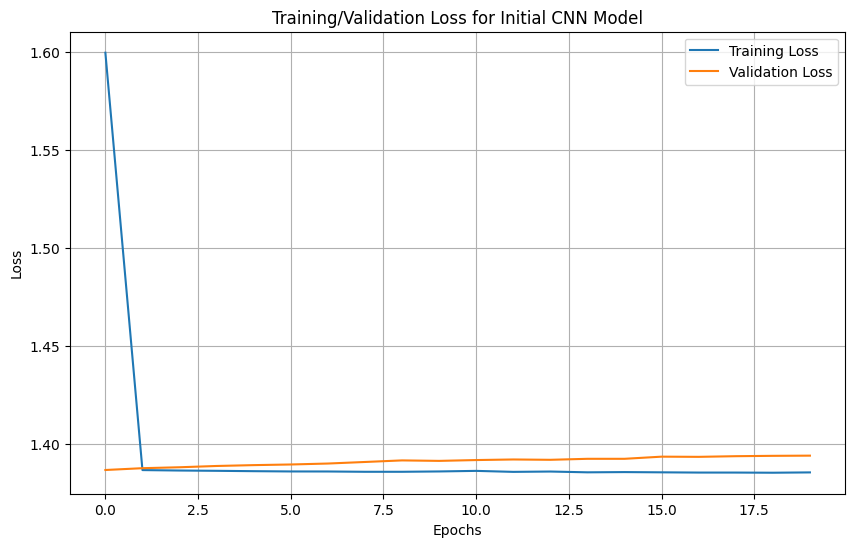

In [63]:
# Plot the training and validation loss for initial CNN model
plot_loss(cnn_history_1, 'Training/Validation Loss for Initial CNN Model')

In [33]:
# Define model used to evaluate model
def evaluate_model(model, x, y):
    loss, accuracy = model.evaluate(x, y)

    # Use model to make predictions
    y_pred = model.predict(x)

    # Compute roc auc score before converting to 1D array in next step
    roc_auc = roc_auc_score(y, y_pred, multi_class='ovr')

    # Convert the predictions' probabilities to the class labels
    y_pred = np.argmax(y_pred, axis=1)

    # Convert one-hot-encoded labels to integer labels
    y_true = np.argmax(y, axis=1)

    # Compute f1, precision, and recall scores
    f1 = f1_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')

    print(f'Accuracy: {accuracy:.3f}')
    print(f'Loss: {loss:.3f}')
    print(f'Recall: {recall:.3f}')
    print(f'Precision: {precision:.3f}')
    print(f'F1 score: {f1:.3f}')
    print(f'ROC AUC score: {roc_auc:.3f}')

    return y_pred, y_true, accuracy, loss, recall, precision, f1, roc_auc


In [34]:
# Evaluate initial model
(y_pred_1, y_true_1, accuracy_1, loss_1, recall_1,
 precision_1, f1_1, roc_auc_1) = evaluate_model(cnn_model, x_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1983 - loss: 1.3938 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 425ms/step
Accuracy: 0.204
Loss: 1.394
Recall: 0.250
Precision: 0.051
F1 score: 0.085
ROC AUC score: 0.500


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### CNN - Model Optimization

In [18]:
# This function builds a model given a set of hyperparameters.
def build_model(hp):
    """
    Builds a convolutional neural network model with hyperparameters.

    The function creates a Sequential model and adds layers to it based on the
    hyperparameters provided. The hyperparameters include the number of filters
    and kernel size for Conv2D layers, the number of units for Dense layers,
    the dropout rate, and the learning rate for the Adam optimizer.

    Parameters:
    hp : HyperParameters
        An instance of Keras Tuner HyperParameters. This object allows you to
        define a hyperparameter search space in a user-friendly way.

    Returns:
    model : Sequential
        The built Keras model. The model is compiled but not trained.

    The model structure is as follows:
    - An input Conv2D layer.
    - A variable number of Conv2D layers, each followed by a MaxPooling2D layer
      and a Dropout layer. The number of layers, the number of filters in the
      Conv2D layers, and the dropout rate are all variable.
    - A Flatten layer.
    - Two Dense layers with a variable number of units, separated by a
      Dropout layer.
    - An output Dense layer with 4 units (one for each class) and a softmax
      activation function for multi-class classfication.

    The model is compiled with the Adam optimizer (with a variable learning
    rate), categorical_crossentropy loss function, and accuracy as the metric.
    """

    model = Sequential()

    #  Input layer with a variable number of filters and kernel size.
    model.add(Conv2D(
        filters=hp.Choice('input_filter',
                          values = [32, 64, 128, 256, 512, 1024, 2048]),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        padding='same',
        input_shape=(128,128,4)
    ))

    current_size = 128  # initial size of the feature maps
    limit_size = 4  # minimum size of the feature maps

    # Add a variable number of Convolutional layers, each with a variable number
    # of filters and kernel size.
    for i in range(hp.Int('num_layers', 2, 8)):  # choice of 2 to 8 layers

        if current_size >= limit_size: # checks that minimum size is not met
            current_size = current_size // 2  # size after pooling

            # Adds convolutional, maxpooling, and dropout layer
            model.add(Conv2D(
                filters=hp.Choice(f'conv_{i+2}_filter',
                                  values = [32, 64, 128, 256, 512, 1024, 2048]),
                kernel_size=hp.Choice(f'conv_{i+2}_kernel', values = [2,5]),
                activation='relu',
                padding='same'
            ))
            model.add(MaxPooling2D(pool_size=(2, 2)))
            model.add(Dropout(rate=hp.Float(f'dropout_{i+2}',
                                            min_value=0.0,
                                            max_value=0.5,
                                            step=0.1)))
        else:
            break  # stop adding layers when the size is reduced to the limit

    # Flatten the output from the Conv2D layers to feed to fully connected layer
    model.add(Flatten())

    # Fully connected layers of Dense and Dropout layers
    model.add(Dense(
        units=hp.Choice('dense_1_units',
                        values = [32, 64, 128, 256, 512, 1024, 2048]),
        activation='relu'
    ))
    model.add(Dropout(rate=hp.Float('dropout_final', min_value=0.0,
                                    max_value=0.5, step=0.1)))
    model.add(Dense(
        units=hp.Choice('dense_2_units',
                        values = [32, 64, 128, 256, 512, 1024, 2048]),
        activation='relu'
    ))

    # Last layer has 4 units and softmax for 4-class classification
    model.add(Dense(4, activation='softmax'))

    # Compile the model using the Adam optimizer with a variable learning rate,
    # categorical_crossentropy as the loss function, and accuracy as the metric.
    model.compile(optimizer=Adam(
                  hp.Choice('learning_rate', values=[0.01, 0.001, 0.0001])),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
#### CODE BLOCK COMMENTED OUT TO PREVENT RUNNING TUNING ####
#### TRIAL RESULTS SAVED ON GITHUB IN "OUTPUT" FOLDER ####

# # Create RandomSearch tuner which tries random combination of hyperparameters.
# tuner = RandomSearch(
#     build_model,
#     objective='val_accuracy',
#     max_trials=10,
#     directory='output',
#     project_name="CNN_Tuning"
# )

# # Print a summary of the search space
# tuner.search_space_summary()

# # Perform the hyperparameter search on validation set
# tuner.search(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

# # Get the optimal hyperparameters
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# # Print a dictionary of the best hyperparameters
# best_hyperparameters = best_hps.values
# print(best_hps.values)

# # Results from all trials
# tuner.results_summary()

In [51]:
# Clear any previous TensorFlow sessions
tf.keras.backend.clear_session()

# Trigger garbage collection to free up unused memory
gc.collect()


0

In [52]:
# Build the optimal CNN model architecture with Trial 3 parameters
cnn_final_model = Sequential([
    # Input layer
    Conv2D(512, (5,5), padding='same',
           activation='relu', input_shape=(128,128,4)),

    #Convolutional layers
    Conv2D(2048, (2,2), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.0),

    Conv2D(1024, (5,5), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(2048, (5,5), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Conv2D(1024, (5,5), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.0),

    Conv2D(256, (5,5), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    Dropout(0.0),

    #Fully-Connected Layer
    Flatten(),
    Dense(2048, activation='relu'),
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(4, activation='softmax')
])

# Print a summary of the model's architecture
cnn_final_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 512)       │          51,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 2048)      │       4,196,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 2048)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64, 64, 2048)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 64, 64, 1024)        │      52,429,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32, 32, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 32, 32, 2048)        │      52,430,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 2048)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16, 16, 2048)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 16, 16, 1024)        │      52,429,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 8, 8, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8, 8, 1024)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 256)           │       6,553,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4096)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │       8,390,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 177,534,212 (677.24 MB)

 Trainable params: 177,534,212 (677.24 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
# Compile the model with learning rate or 0.0001
cnn_final_model.compile(optimizer=Adam(learning_rate=0.0001),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])


In [54]:
# Train the optimal model on training set and store training/validation loss
cnn_history_2 = cnn_final_model.fit(x_train, y_train, batch_size=32, epochs=20,
          validation_data=(x_val, y_val))

Epoch 1/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 18s 947ms/step - accuracy: 0.2877 - loss: 1.4387 - val_accuracy: 0.2037 - val_loss: 1.3967
Epoch 2/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 588ms/step - accuracy: 0.2675 - loss: 1.3853 - val_accuracy: 0.2037 - val_loss: 1.3882
Epoch 3/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 587ms/step - accuracy: 0.2679 - loss: 1.3856 - val_accuracy: 0.2037 - val_loss: 1.3907
Epoch 4/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 587ms/step - accuracy: 0.2585 - loss: 1.3852 - val_accuracy: 0.2037 - val_loss: 1.3884
Epoch 5/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 588ms/step - accuracy: 0.2852 - loss: 1.3849 - val_accuracy: 0.2037 - val_loss: 1.3881
Epoch 6/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 588ms/step - accuracy: 0.3010 - loss: 1.3833 - val_accuracy: 0.2037 - val_loss: 1.3838
Epoch 7/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 588ms/step - accuracy: 0.2754 - loss: 1.3726 - val_accuracy: 0.2593 - val_loss: 1.3199
Epoch 8/20
14/14 ━━━━━━━━━━━━━━━━━━━━ 8s 588ms/step - accuracy: 0.3117 - loss: 1.2905 - val_accuracy: 0

### CNN - Model Evaluation

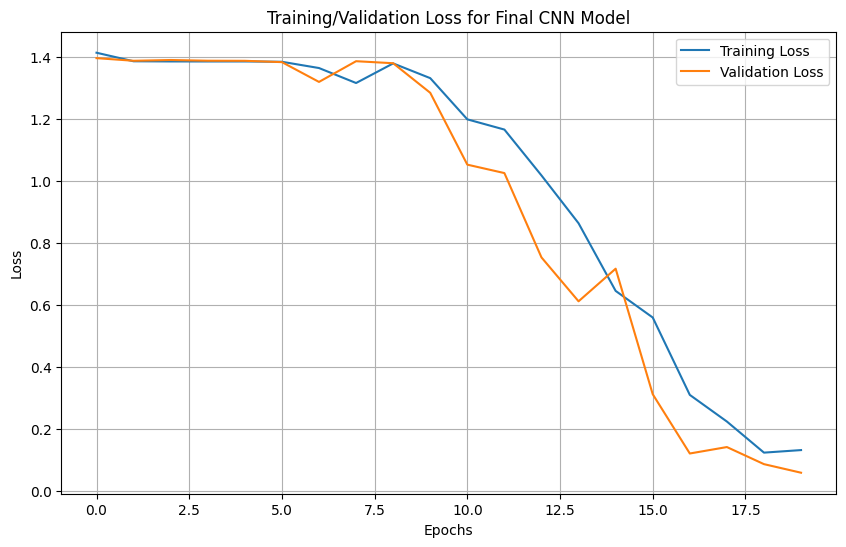

In [64]:
# Plot the training and validation loss for final CNN model
plot_loss(cnn_history_2, 'Training/Validation Loss for Final CNN Model')

In [56]:
# Evaluate the optimal model on the validation set
(y_pred_2, y_true_2, accuracy_2, loss_2,
 recall_2, precision_2, f1_2, roc_auc_2) = evaluate_model(cnn_final_model,
                                                          x_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9545 - loss: 0.0581
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
Accuracy: 0.963
Loss: 0.058
Recall: 0.959
Precision: 0.966
F1 score: 0.961
ROC AUC score: 1.000


In [57]:
# Evaluate the optimal model the test set
(y_pred_3, y_true_3, accuracy_3, loss_3,
 recall_3, precision_3, f1_3, roc_auc_3) = evaluate_model(cnn_final_model,
                                                          x_test, y_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step - accuracy: 0.9879 - loss: 0.0293
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
Accuracy: 0.982
Loss: 0.032
Recall: 0.982
Precision: 0.985
F1 score: 0.983
ROC AUC score: 1.000


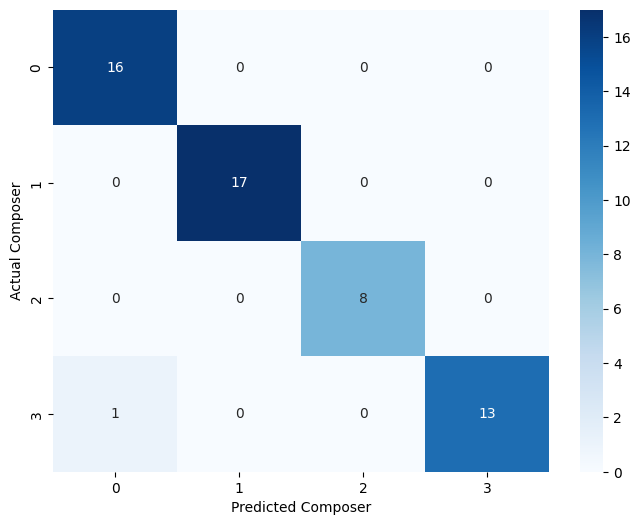

In [58]:
# Create confusion matrix for classification on test set
cm = confusion_matrix(y_true_3, y_pred_3)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Composer')
plt.ylabel('Actual Composer')
plt.show()

Layer: conv2d
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


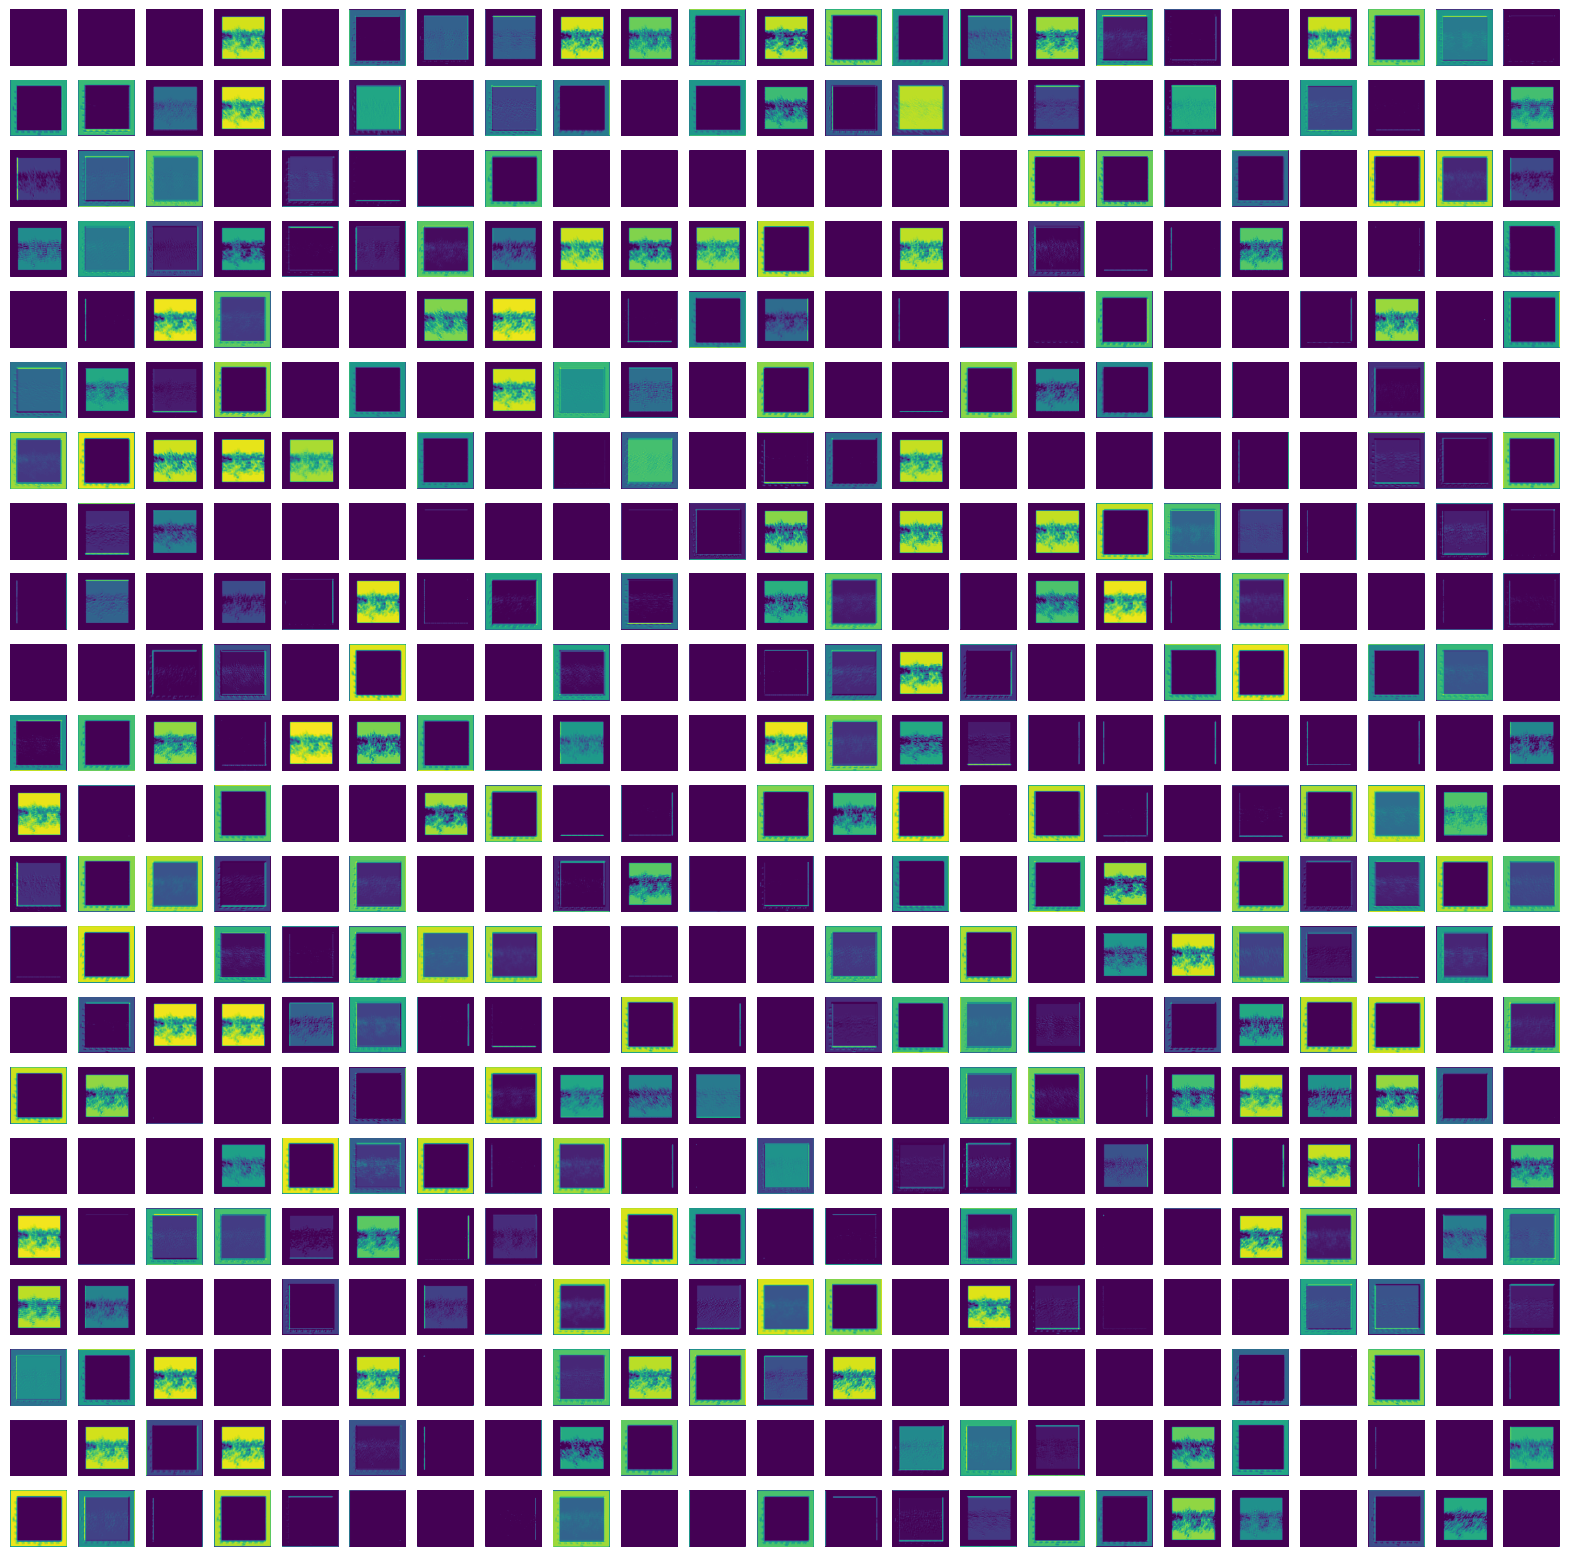

Layer: conv2d_1
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step


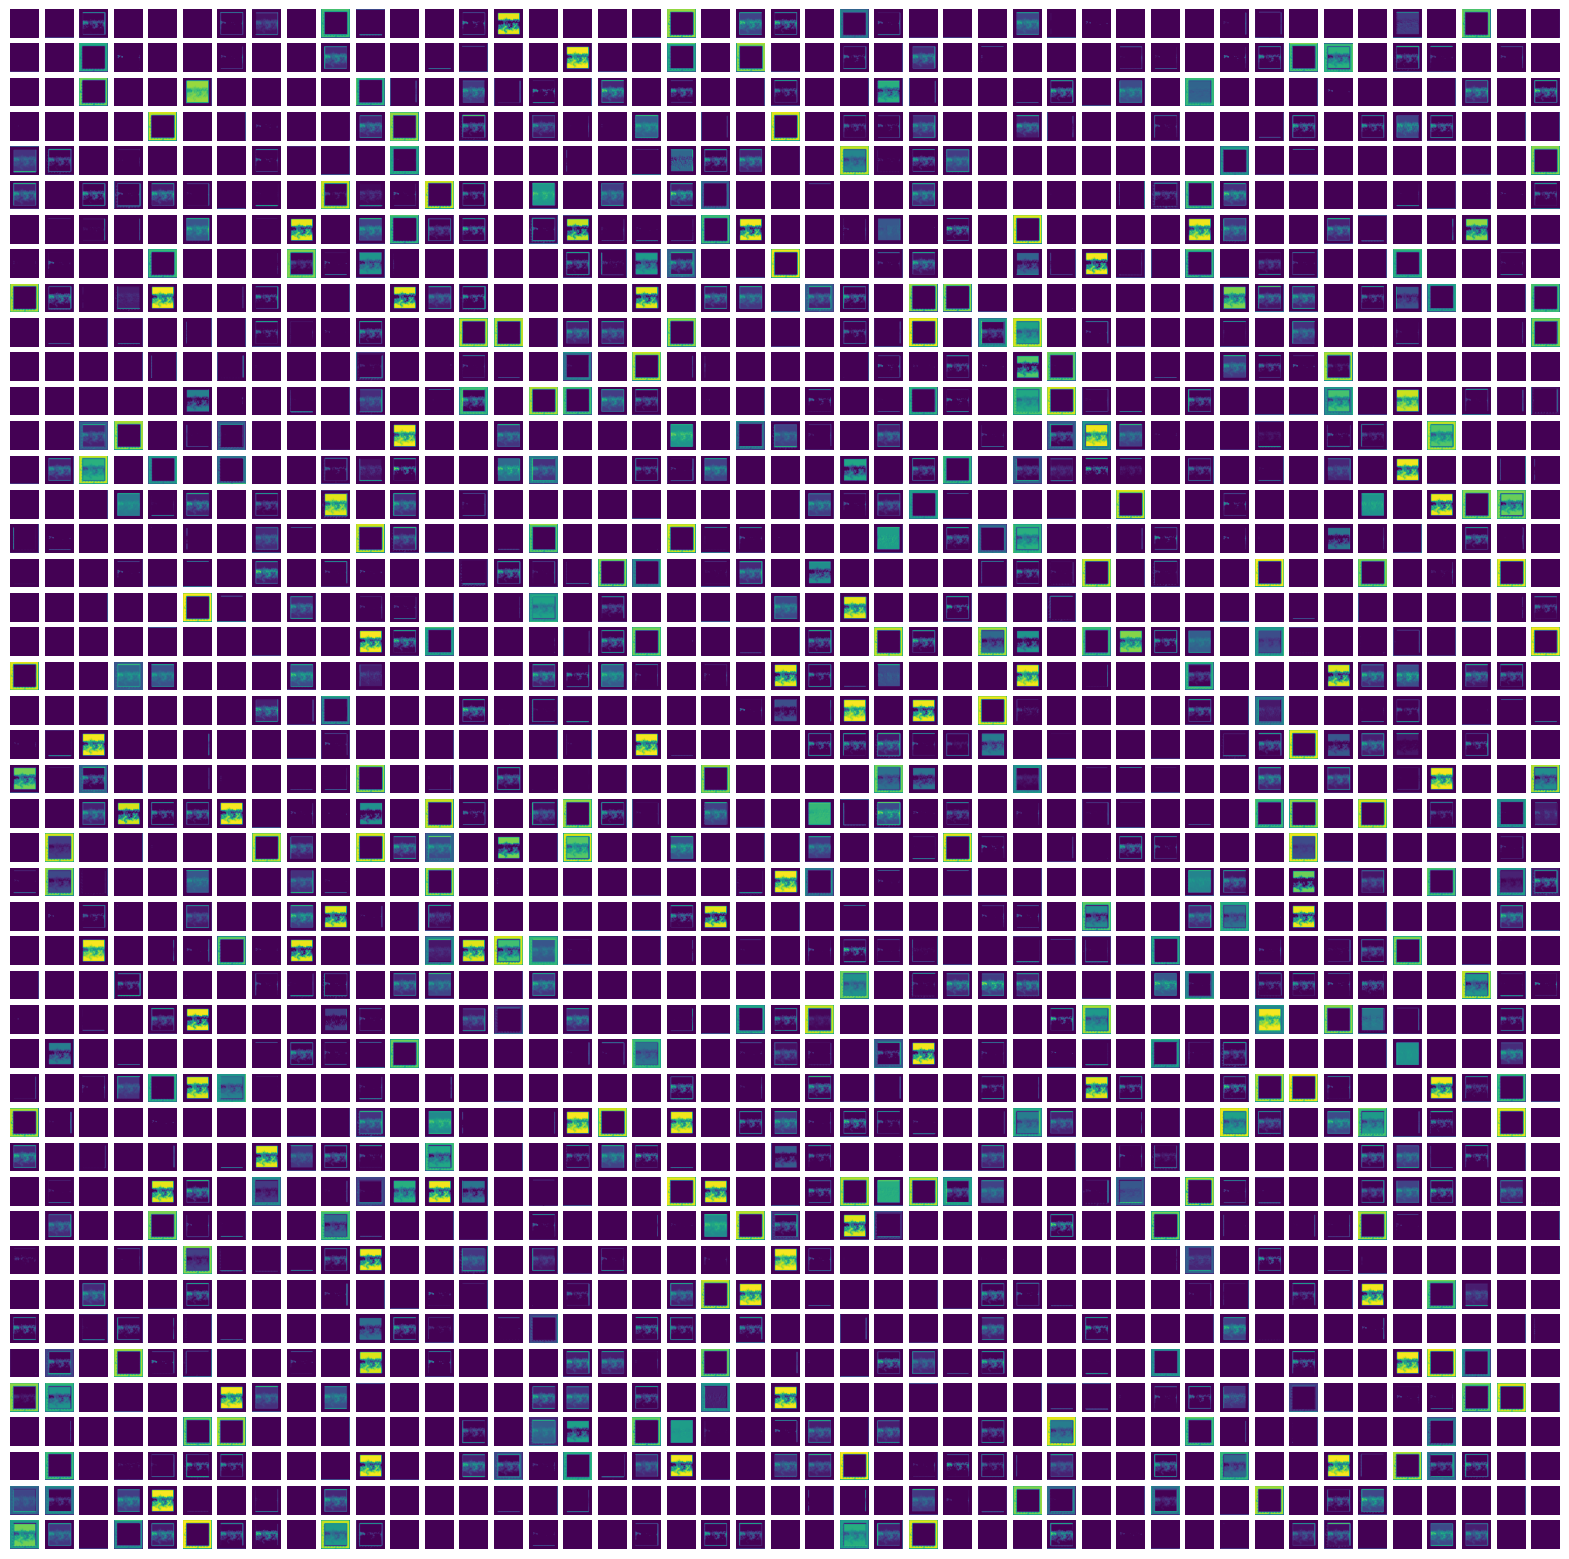

Layer: conv2d_2
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


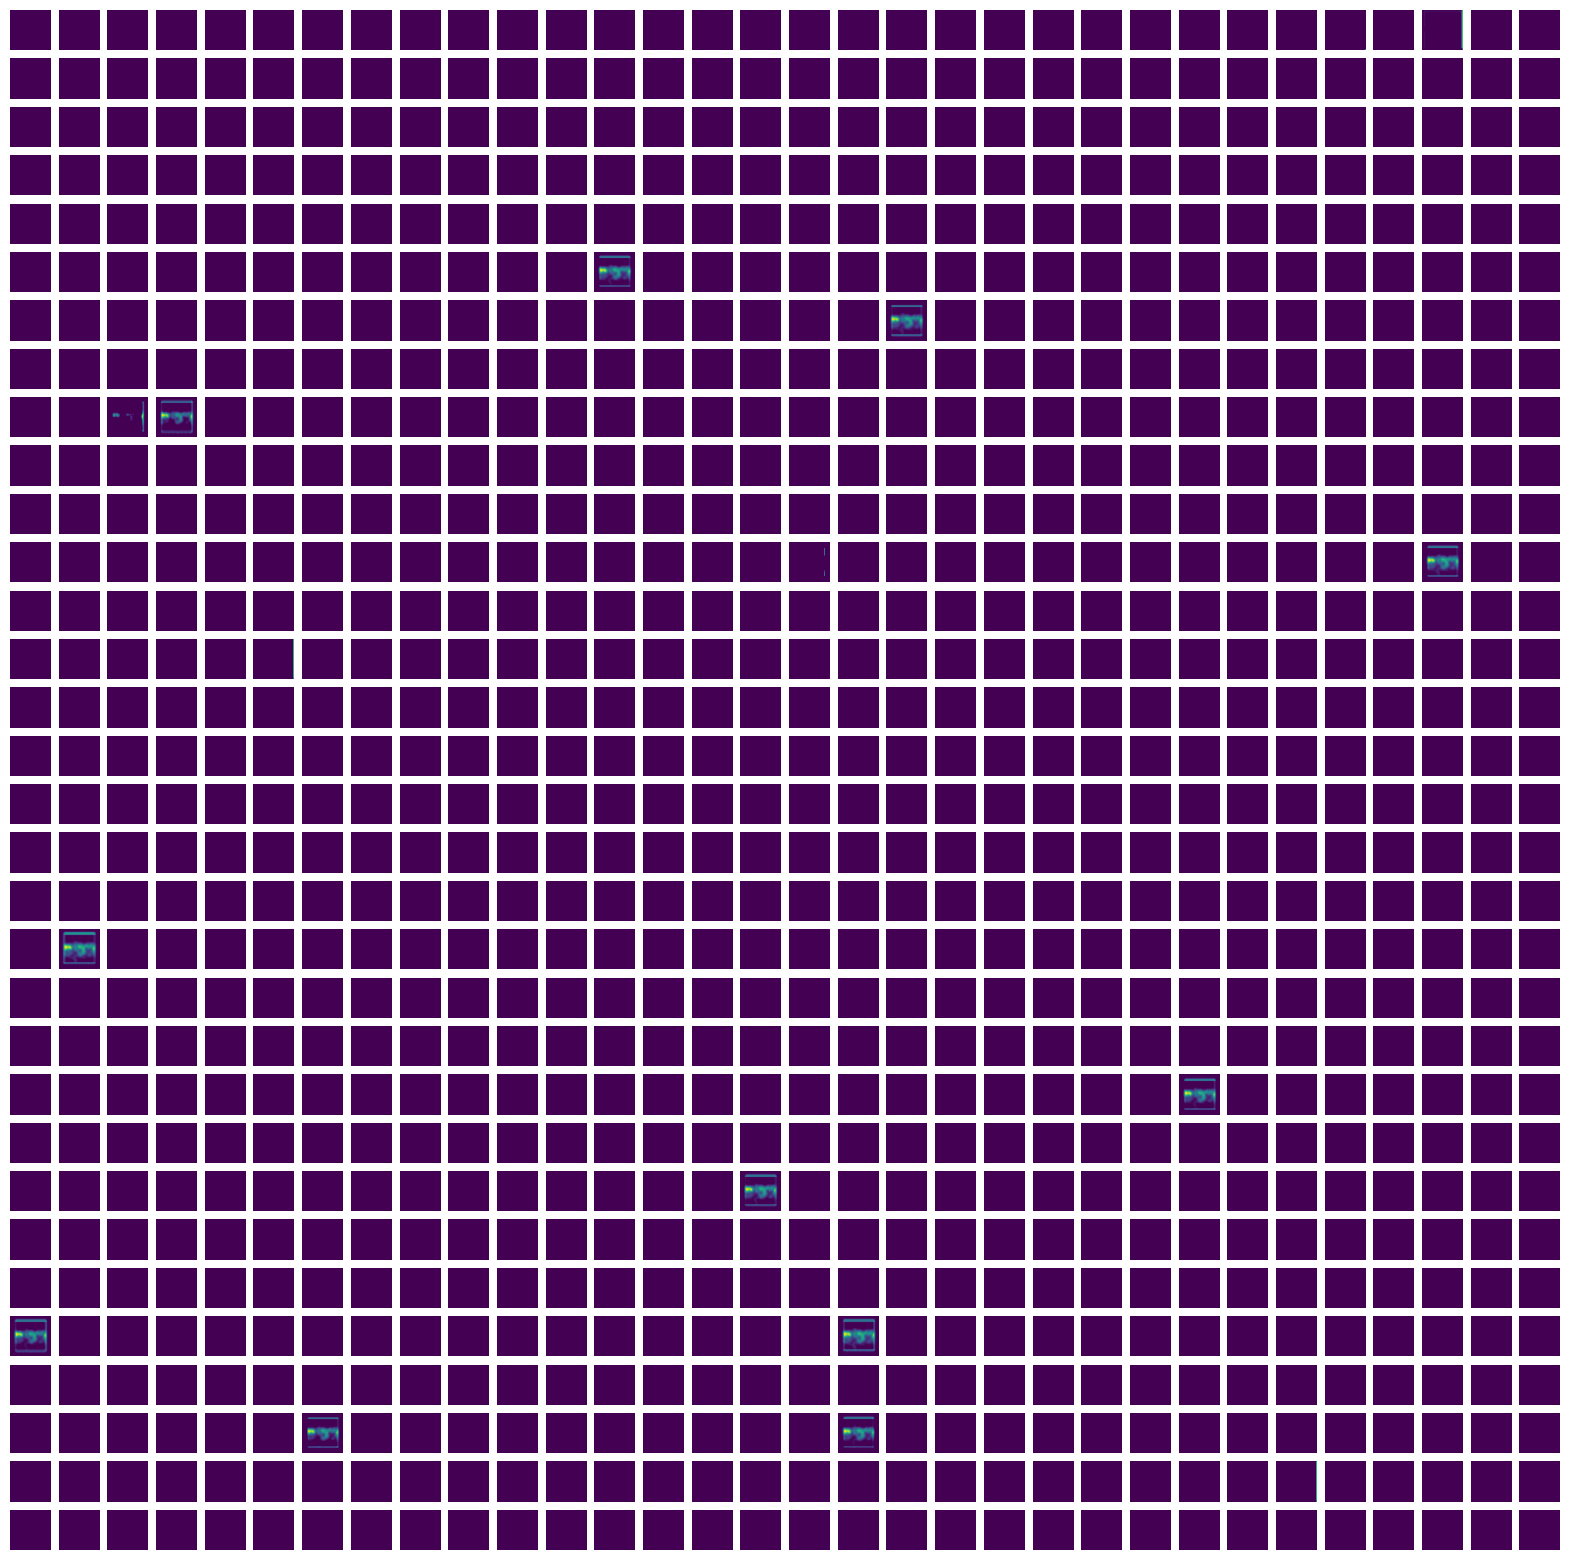

Layer: conv2d_3
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step


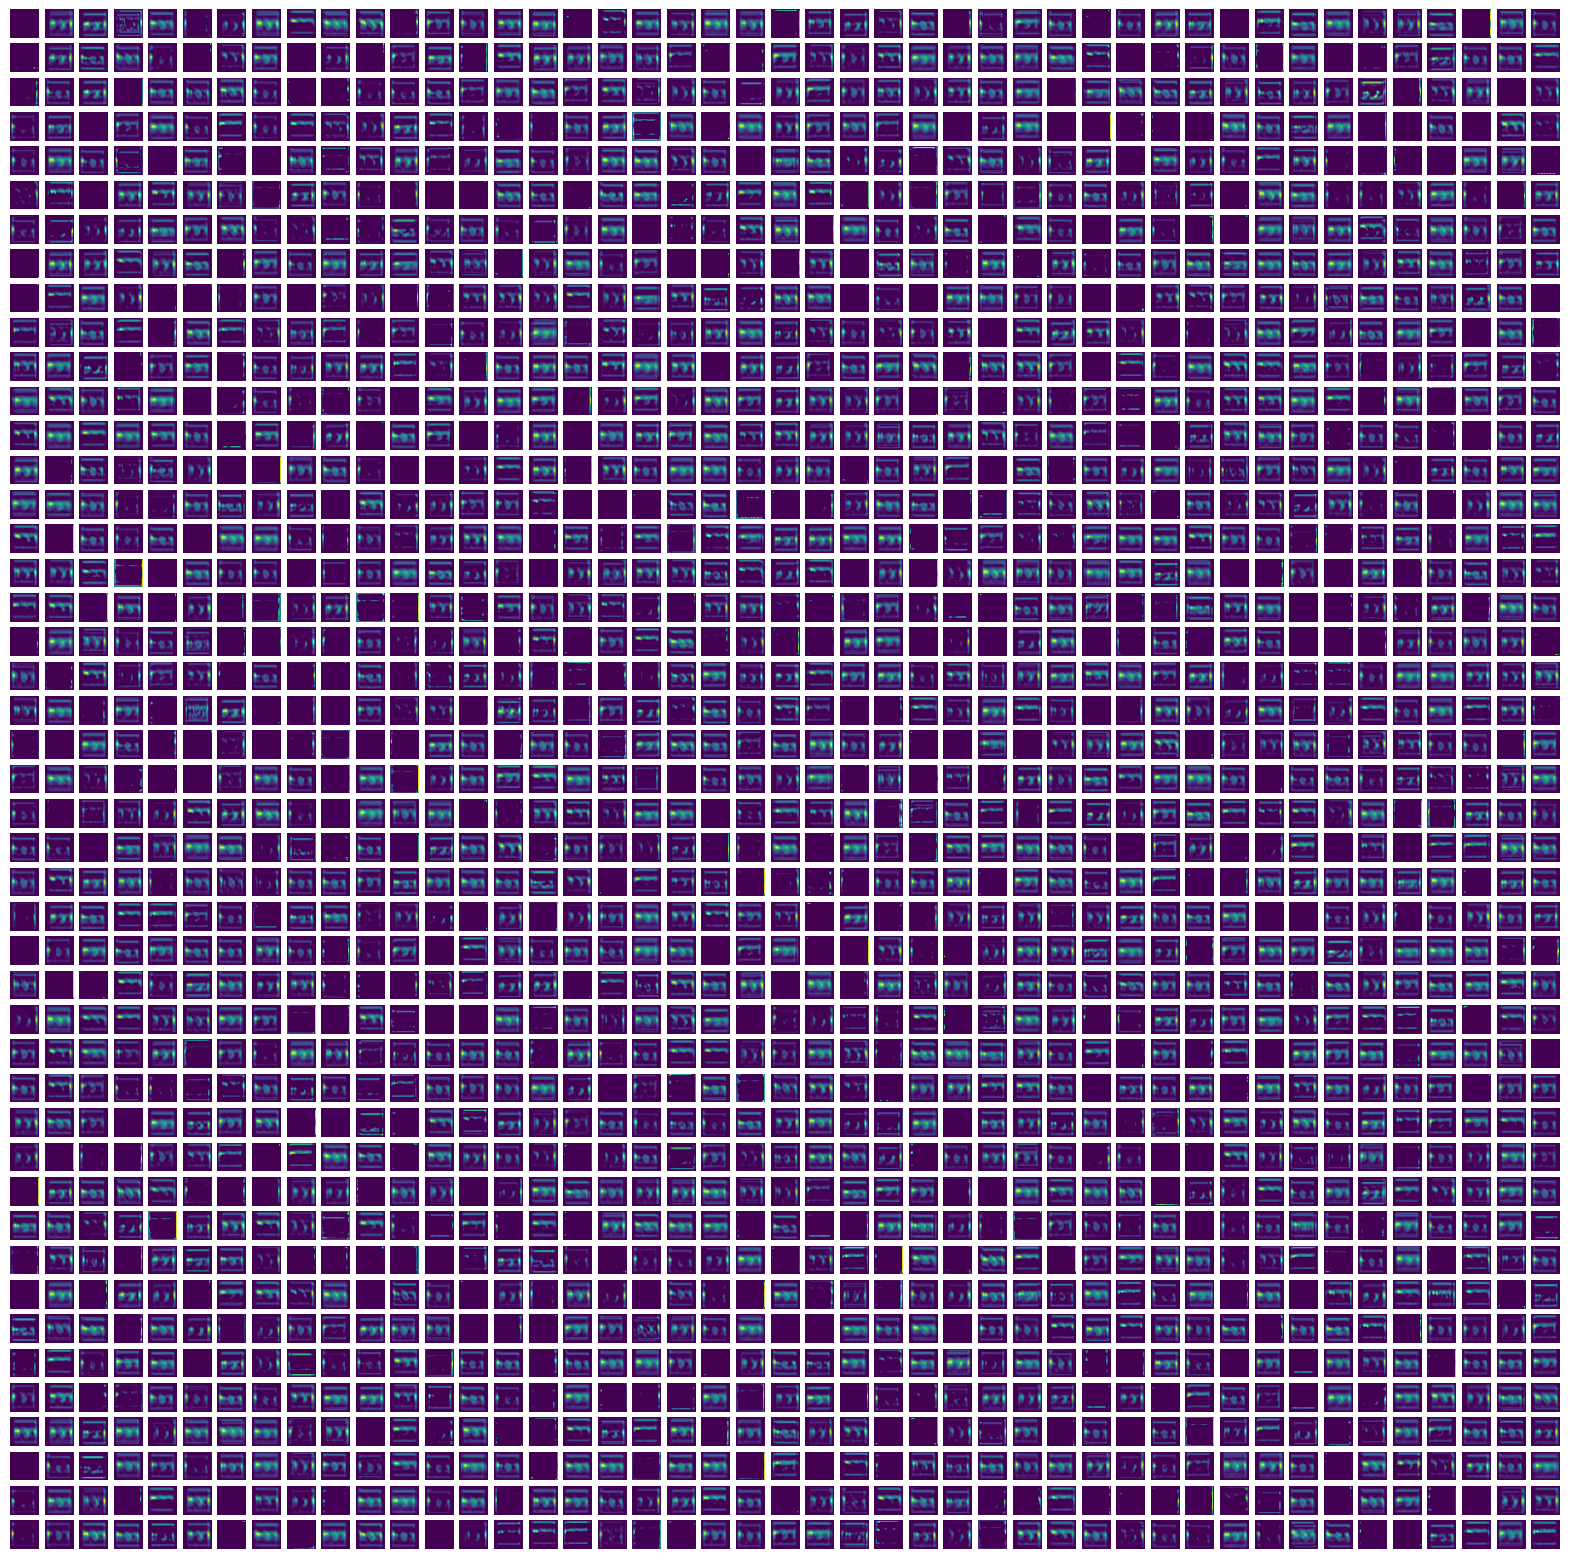

Layer: conv2d_4
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 322ms/step


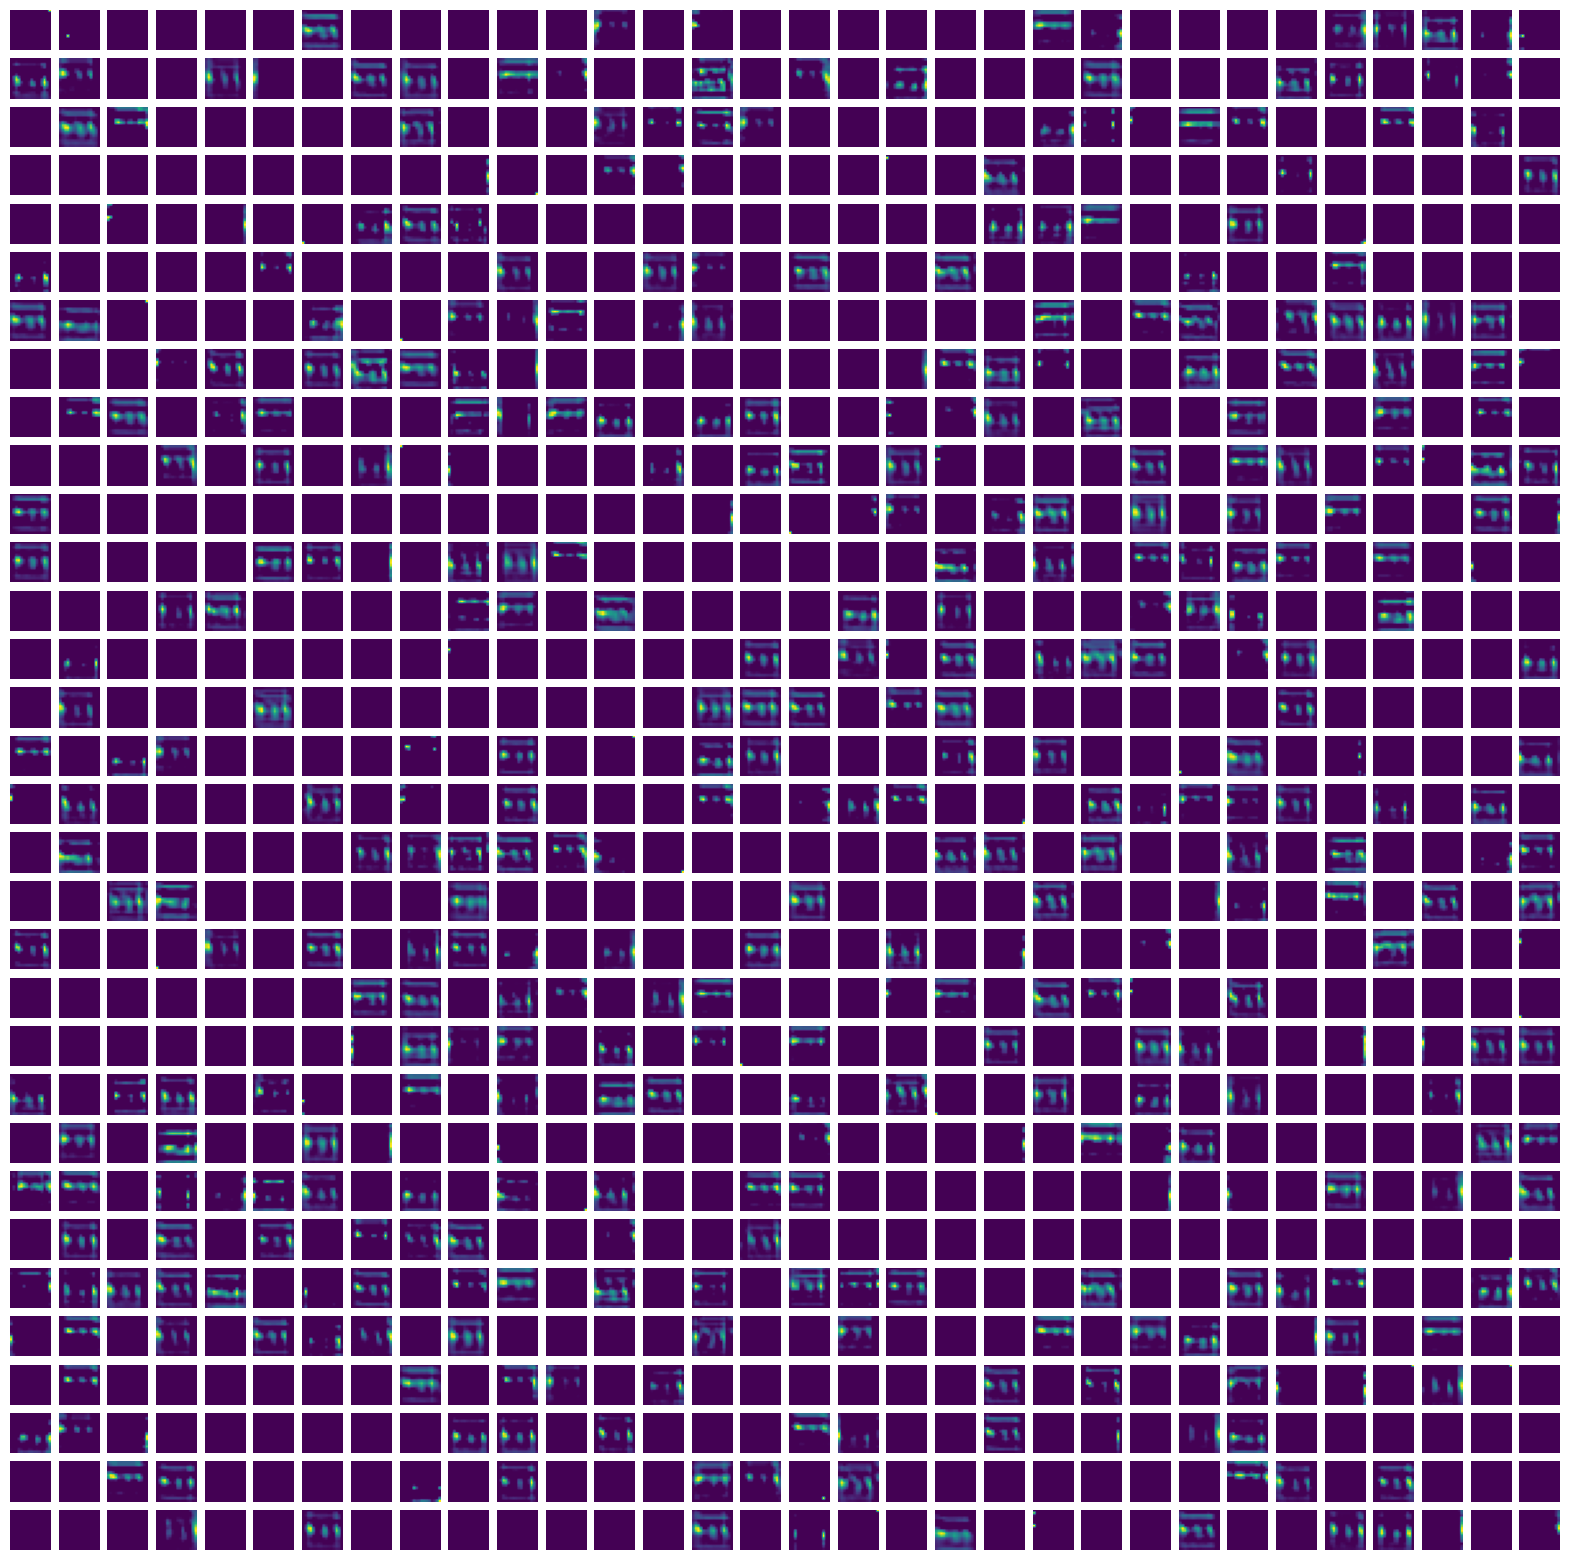

Layer: conv2d_5
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 357ms/step


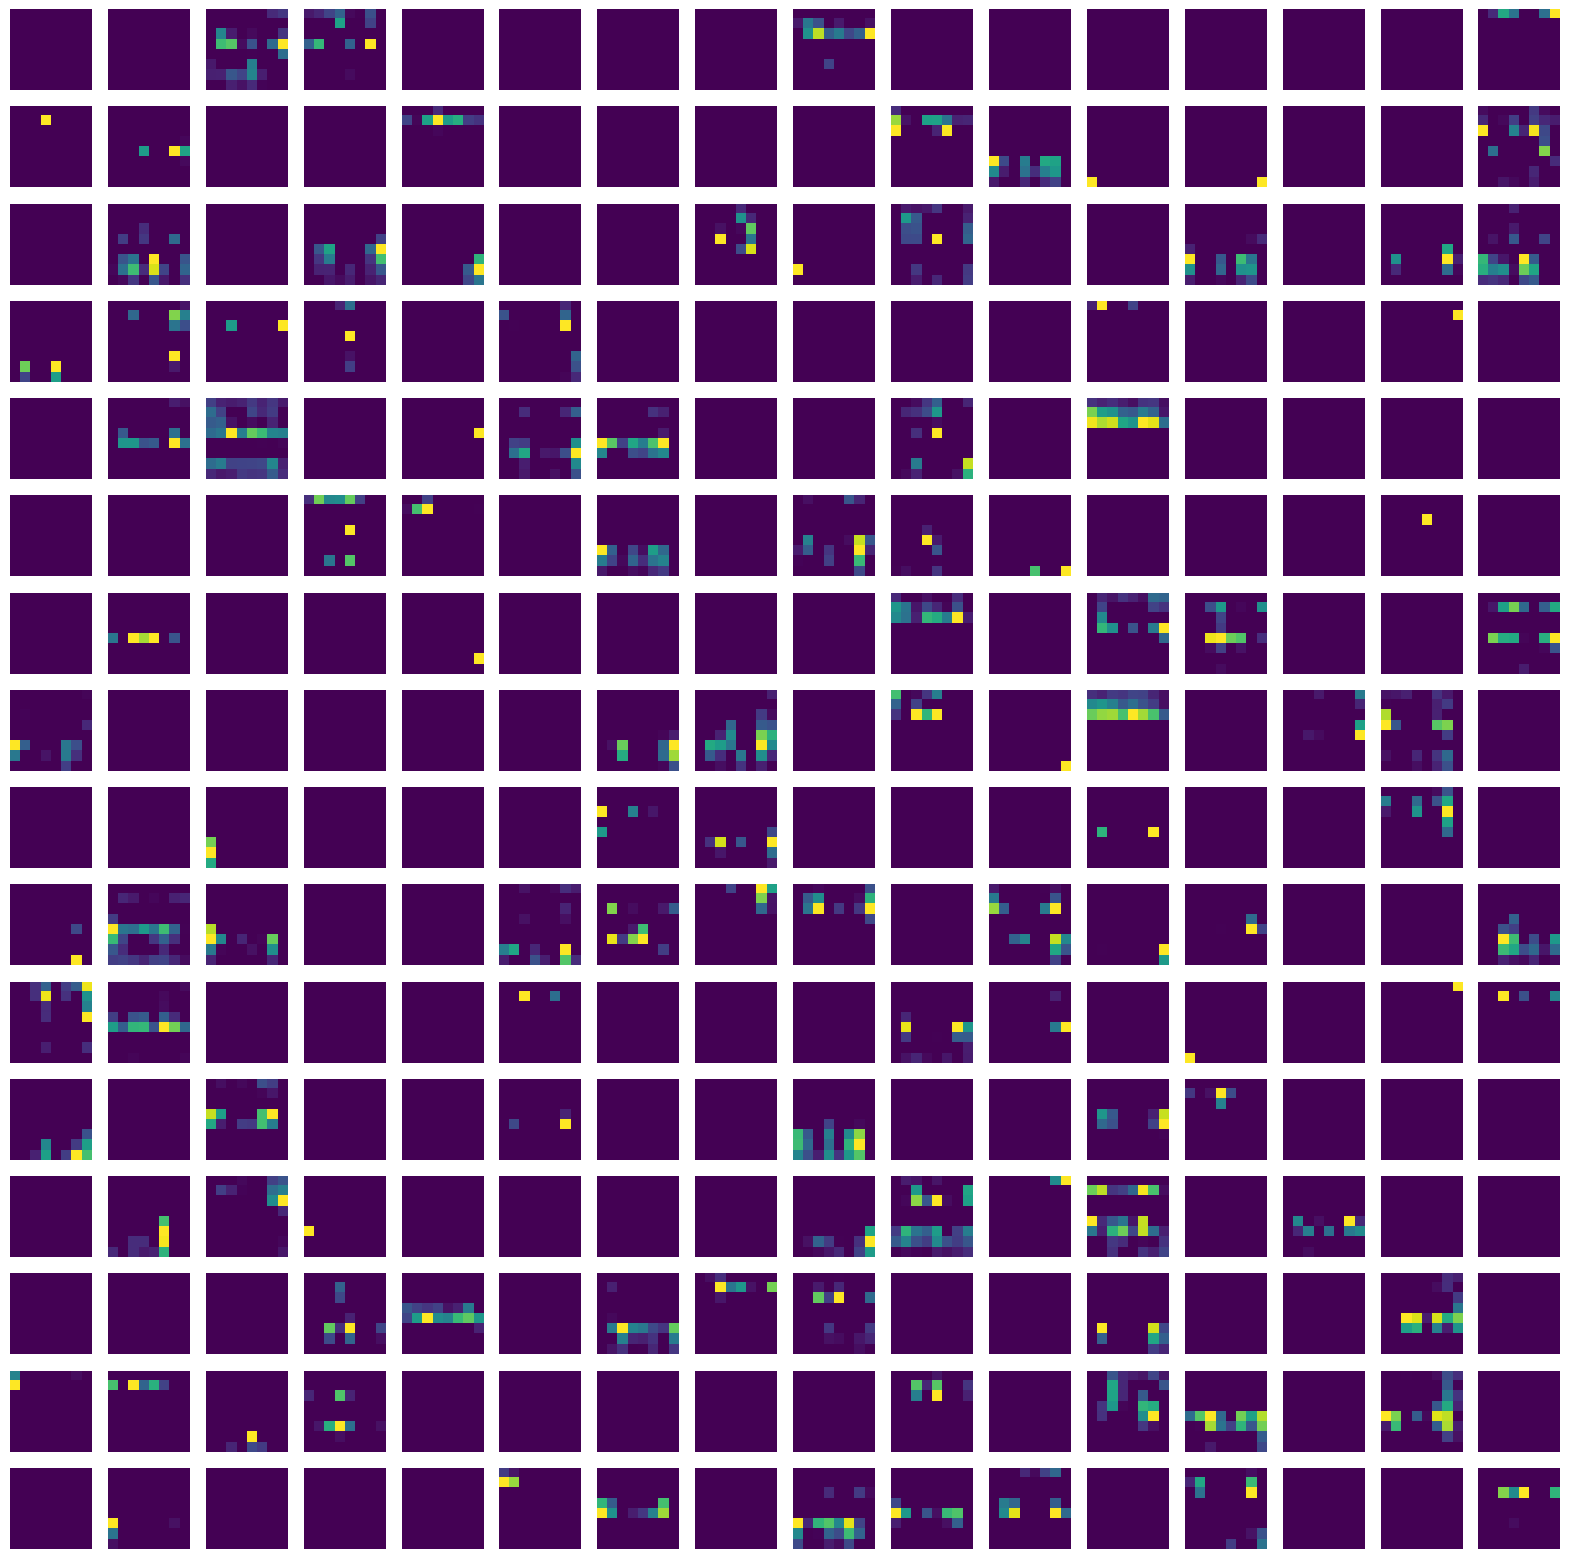

In [59]:
# Visualize the activations of each convolutional layer for the final model

# Name of layers
layers = ['conv2d', 'conv2d_1', 'conv2d_2', 'conv2d_3', 'conv2d_4',
          'conv2d_5']

# Iterate over each layer and print the layer's name
for name in layers:
    print('Layer:', name)

    # Select the layer to visualize
    layer_name = name

    # Creates a new model that has the same input as your original model
    # but outputs the activations of the selected layer.
    layer_model = Model(inputs=cnn_final_model.layers[0].input,
                        outputs=cnn_final_model.get_layer(layer_name).output)

    # Use the new model to make predictions on test data.
    # This gives the activations of the selected layer.
    activation_output = layer_model.predict(x_test)

    # Visualize the output of the first image in 'x_test'
    first_image_output = activation_output[0]

    # Name dimensions of the output shape.
    height, width, num_filters = first_image_output.shape

    # Arrange the images in a grid.
    grid_height = int(num_filters**0.5)
    grid_width = num_filters // grid_height

    # Create a figure with a subplot for each image.
    fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))

    for i in range(grid_height):
        for j in range(grid_width):
            # Extract the image for this filter
            filter_img = first_image_output[:, :, i*grid_width + j]
            # Display the image in the corresponding subplot
            axs[i, j].imshow(filter_img, cmap='viridis')
            # Hide the axes
            axs[i, j].axis('off')

    # Display the figure
    plt.show()